# CBU5201 Mini-Project
# 1. Author

**Student Name:** Minghui Pan

**Student ID:** 231220208

In [ ]:
from __future__ import annotations

import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

# ---------------------------------------------------------------------
# 0) Environment setup (keeps CPU threading stable inside notebooks)
# ---------------------------------------------------------------------
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
os.environ.setdefault("NUMBA_DISABLE_JIT", "1")

import librosa
import numpy as np
from __future__ import annotations
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

# ---------------------------------------------------------------------
# 1) Paths and constants (edit for your machine)
# ---------------------------------------------------------------------
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_OUTPUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover - fallback when tqdm is unavailable
    tqdm = None


# ---------------------------------------------------------------------
# 2) Configuration object
# ---------------------------------------------------------------------
@dataclass
class FeatureConfig:
    sr: int = 22050
    n_mfcc: int = 13
    hop_length: int = 512
    fmin: float = librosa.note_to_hz("C2")
    fmax: float = librosa.note_to_hz("C7")
    onset_backtrack: bool = True


# ---------------------------------------------------------------------
# 3) Small numeric helpers
# ---------------------------------------------------------------------
def _safe_stats(x: np.ndarray) -> Tuple[float, float, float, float]:
    if x.size == 0:
        return 0.0, 0.0, 0.0, 0.0
    return float(np.mean(x)), float(np.std(x)), float(np.max(x)), float(np.min(x))


def _safe_mean_std(x: np.ndarray) -> Tuple[float, float]:
    if x.size == 0:
        return 0.0, 0.0
    return float(np.mean(x)), float(np.std(x))


def _nan_to_num(x: np.ndarray) -> np.ndarray:
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)


# ---------------------------------------------------------------------
# 4) Audio loading
# ---------------------------------------------------------------------
def load_audio(path: str, cfg: FeatureConfig) -> Tuple[np.ndarray, int]:
    y, sr = librosa.load(path, sr=cfg.sr, mono=True)
    if y.size == 0:
        return np.zeros(1, dtype=np.float32), cfg.sr
    return y, sr


# ---------------------------------------------------------------------
# 5) MFCC + delta features
# ---------------------------------------------------------------------
def mfcc_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    mfcc = librosa.feature.mfcc(
        y=y, sr=cfg.sr, n_mfcc=cfg.n_mfcc, hop_length=cfg.hop_length
    )
    delta = librosa.feature.delta(mfcc)

    mfcc = _nan_to_num(mfcc)
    delta = _nan_to_num(delta)

    feats: List[float] = []
    feats.extend(np.mean(mfcc, axis=1).tolist())
    feats.extend(np.std(mfcc, axis=1).tolist())
    feats.extend(np.mean(delta, axis=1).tolist())
    feats.extend(np.std(delta, axis=1).tolist())
    return feats


# ---------------------------------------------------------------------
# 6) F0 / pitch contour features (pyin)
# ---------------------------------------------------------------------
def f0_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y,
        fmin=cfg.fmin,
        fmax=cfg.fmax,
        sr=cfg.sr,
        hop_length=cfg.hop_length,
    )
    f0 = _nan_to_num(f0)
    voiced_flag = voiced_flag.astype(np.float32) if voiced_flag is not None else None

    voiced_ratio = 0.0
    if voiced_flag is not None and voiced_flag.size > 0:
        voiced_ratio = float(np.mean(voiced_flag))

    f0_mean, f0_std = _safe_mean_std(f0)
    if f0_std > 0:
        f0_norm = (f0 - f0_mean) / f0_std
    else:
        f0_norm = f0 - f0_mean

    f0n_mean, f0n_std = _safe_mean_std(f0_norm)
    f0n_max, f0n_min = (float(np.max(f0_norm)), float(np.min(f0_norm))) if f0_norm.size else (0.0, 0.0)
    f0n_median = float(np.median(f0_norm)) if f0_norm.size else 0.0

    # Interval in semitones between adjacent frames.
    f0_nonzero = np.where(f0 > 0, f0, np.nan)
    intervals = 12.0 * np.log2(f0_nonzero[1:] / f0_nonzero[:-1])
    intervals = _nan_to_num(intervals)

    int_mean, int_std, int_max, int_min = _safe_stats(intervals)
    int_median = float(np.median(intervals)) if intervals.size else 0.0
    int_iqr = float(np.percentile(intervals, 75) - np.percentile(intervals, 25)) if intervals.size else 0.0
    int_abs_mean = float(np.mean(np.abs(intervals))) if intervals.size else 0.0
    int_abs_std = float(np.std(np.abs(intervals))) if intervals.size else 0.0
    int_pos_ratio = float(np.mean(intervals > 0)) if intervals.size else 0.0
    int_neg_ratio = float(np.mean(intervals < 0)) if intervals.size else 0.0

    # Melodic contour proportions.
    eps = 1e-4
    up_ratio = float(np.mean(intervals > eps)) if intervals.size else 0.0
    down_ratio = float(np.mean(intervals < -eps)) if intervals.size else 0.0
    flat_ratio = float(np.mean(np.abs(intervals) <= eps)) if intervals.size else 0.0

    feats = [
        f0n_mean,
        f0n_std,
        f0n_max,
        f0n_min,
        f0n_median,
        int_mean,
        int_std,
        int_max,
        int_min,
        int_median,
        int_iqr,
        int_abs_mean,
        int_abs_std,
        int_pos_ratio,
        int_neg_ratio,
        up_ratio,
        down_ratio,
        flat_ratio,
        voiced_ratio,
        float(np.mean(_nan_to_num(voiced_prob))) if voiced_prob is not None else 0.0,
    ]
    return feats


# ---------------------------------------------------------------------
# 7) Rhythm / onset features
# ---------------------------------------------------------------------
def _estimate_tempo(onset_env: np.ndarray, cfg: FeatureConfig) -> float:
    if onset_env.size < 2:
        return 0.0
    onset_env = onset_env - np.mean(onset_env)
    if np.allclose(onset_env, 0.0):
        return 0.0
    ac = np.correlate(onset_env, onset_env, mode="full")[onset_env.size - 1 :]
    min_bpm, max_bpm = 30.0, 240.0
    min_lag = int((60.0 * cfg.sr) / (max_bpm * cfg.hop_length))
    max_lag = int((60.0 * cfg.sr) / (min_bpm * cfg.hop_length))
    min_lag = max(min_lag, 1)
    max_lag = min(max_lag, ac.size - 1)
    if max_lag <= min_lag:
        return 0.0
    lag = int(np.argmax(ac[min_lag : max_lag + 1]) + min_lag)
    return float(60.0 * cfg.sr / (cfg.hop_length * lag))


def rhythm_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    onset_env = librosa.onset.onset_strength(y=y, sr=cfg.sr, hop_length=cfg.hop_length)
    onset_frames = librosa.onset.onset_detect(
        onset_envelope=onset_env,
        sr=cfg.sr,
        hop_length=cfg.hop_length,
        backtrack=cfg.onset_backtrack,
    )
    onset_times = librosa.frames_to_time(onset_frames, sr=cfg.sr, hop_length=cfg.hop_length)
    ioi = np.diff(onset_times)
    ioi_mean, ioi_std, ioi_max, ioi_min = _safe_stats(ioi)

    tempo = _estimate_tempo(onset_env, cfg)
    duration = float(len(y)) / float(cfg.sr) if cfg.sr > 0 else 0.0
    onsets_per_sec = float(len(onset_times) / duration) if duration > 0 else 0.0

    return [
        ioi_mean,
        ioi_std,
        ioi_max,
        ioi_min,
        tempo,
        onsets_per_sec,
    ]


# ---------------------------------------------------------------------
# 8) Full feature vector helpers
# ---------------------------------------------------------------------
def extract_features(path: str, cfg: FeatureConfig | None = None) -> np.ndarray:
    cfg = cfg or FeatureConfig()
    y, _ = load_audio(path, cfg)
    feats: List[float] = []
    feats.extend(mfcc_features(y, cfg))
    feats.extend(f0_features(y, cfg))
    feats.extend(rhythm_features(y, cfg))
    return np.asarray(feats, dtype=np.float32)


def batch_extract(
    paths: Iterable[str], cfg: FeatureConfig | None = None
) -> Tuple[np.ndarray, List[str]]:
    cfg = cfg or FeatureConfig()
    features: List[np.ndarray] = []
    ok_paths: List[str] = []
    path_list = list(paths)
    if tqdm is not None:
        iterator = tqdm(path_list, desc="Extracting features", unit="file")
    else:
        iterator = path_list
    for idx, p in enumerate(iterator, start=1):
        feats = extract_features(p, cfg)
        features.append(feats)
        ok_paths.append(p)
        if tqdm is None and idx % 50 == 0:
            print(f"Processed {idx}/{len(path_list)} files...")
    return np.vstack(features), ok_paths


def feature_names(cfg: FeatureConfig | None = None) -> List[str]:
    cfg = cfg or FeatureConfig()
    names: List[str] = []
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_mean_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_std_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_delta_mean_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_delta_std_{i+1}")

    names.extend(
        [
            "f0n_mean",
            "f0n_std",
            "f0n_max",
            "f0n_min",
            "f0n_median",
            "interval_mean",
            "interval_std",
            "interval_max",
            "interval_min",
            "interval_median",
            "interval_iqr",
            "interval_abs_mean",
            "interval_abs_std",
            "interval_pos_ratio",
            "interval_neg_ratio",
            "contour_up_ratio",
            "contour_down_ratio",
            "contour_flat_ratio",
            "voiced_ratio",
            "voiced_prob_mean",
        ]
    )

    names.extend(
        [
            "ioi_mean",
            "ioi_std",
            "ioi_max",
            "ioi_min",
            "tempo",
            "onsets_per_sec",
        ]
    )
    return names


def as_dict(path: str, cfg: FeatureConfig | None = None) -> Dict[str, float]:
    cfg = cfg or FeatureConfig()
    feats = extract_features(path, cfg)
    names = feature_names(cfg)
    return {k: float(v) for k, v in zip(names, feats)}


# ---------------------------------------------------------------------
# 9) Dataset helpers (metadata + saving)
# ---------------------------------------------------------------------
def _parse_metadata(path: Path) -> Dict[str, str]:
    stem = path.stem
    parts = stem.split("_")
    meta = {"subject": "", "mode": "", "take": "", "song": ""}
    if len(parts) >= 4:
        meta["subject"] = parts[0]
        meta["mode"] = parts[1]
        meta["take"] = parts[2]
        meta["song"] = "_".join(parts[3:])
    else:
        meta["song"] = stem
    return meta


def collect_wav_paths(data_dir: Path) -> List[Path]:
    return sorted([p for p in data_dir.glob("*.wav") if p.is_file()])


def save_features(
    features: np.ndarray,
    paths: List[str],
    names: List[str],
    meta: List[Dict[str, str]],
    out_dir: Path,
    prefix: str,
) -> None:
    out_dir.mkdir(parents=True, exist_ok=True)
    npz_path = out_dir / f"{prefix}.npz"
    csv_path = out_dir / f"{prefix}.csv"

    labels = [m.get("song", "") for m in meta]
    np.savez_compressed(
        npz_path,
        X=features,
        labels=np.asarray(labels),
        paths=np.asarray(paths),
        feature_names=np.asarray(names),
        subject=np.asarray([m.get("subject", "") for m in meta]),
        mode=np.asarray([m.get("mode", "") for m in meta]),
        take=np.asarray([m.get("take", "") for m in meta]),
    )

    header = ["path", "label", "subject", "mode", "take"] + names
    with csv_path.open("w", encoding="utf-8", newline="") as f:
        f.write(",".join(header) + "\n")
        for row_idx, p in enumerate(paths):
            row = [
                p,
                labels[row_idx],
                meta[row_idx].get("subject", ""),
                meta[row_idx].get("mode", ""),
                meta[row_idx].get("take", ""),
            ]
            feat_str = [f"{v:.8f}" for v in features[row_idx].tolist()]
            f.write(",".join(row + feat_str) + "\n")
# NOTE: We already extracted and saved the features offline, so re-running
# this block is unnecessary and can be time-consuming.
# cfg = FeatureConfig()
# wav_paths = collect_wav_paths(DATASET_DIR)
# features, ok_paths = batch_extract([str(p) for p in wav_paths], cfg)
# meta = [_parse_metadata(Path(p)) for p in ok_paths]
# names = feature_names(cfg)
# save_features(features, ok_paths, names, meta, DEFAULT_OUTPUT_DIR, "features")


In [ ]:
##数据增强代码
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Tuple

import librosa
import numpy as np
from scipy.io import wavfile

# ---------------------------------------------------------------------
# 1) Paths (edit for your machine)
# ---------------------------------------------------------------------
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_OUTPUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/data/augmented")


# ---------------------------------------------------------------------
# 2) Augmentation config
# ---------------------------------------------------------------------
@dataclass
class AugmentConfig:
    sr: int = 22050
    pitch_shift_steps: Tuple[int, int] = (-3, 3)
    time_stretch_range: Tuple[float, float] = (0.9, 1.1)
    snr_db_range: Tuple[float, float] = (20.0, 40.0)


# ---------------------------------------------------------------------
# 3) Audio loading
# ---------------------------------------------------------------------
def load_audio(path: str | Path, cfg: AugmentConfig) -> np.ndarray:
    y, _ = librosa.load(str(path), sr=cfg.sr, mono=True)
    if y.size == 0:
        return np.zeros(1, dtype=np.float32)
    return y.astype(np.float32, copy=False)


# ---------------------------------------------------------------------
# 4) Augmentation ops
# ---------------------------------------------------------------------
def pitch_shift(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    steps = rng.integers(cfg.pitch_shift_steps[0], cfg.pitch_shift_steps[1] + 1)
    if steps == 0:
        return y
    return librosa.effects.pitch_shift(y, sr=cfg.sr, n_steps=int(steps))


def time_stretch(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    rate = rng.uniform(cfg.time_stretch_range[0], cfg.time_stretch_range[1])
    if np.isclose(rate, 1.0):
        return y
    return librosa.effects.time_stretch(y, rate=float(rate))


def add_noise(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    snr_db = rng.uniform(cfg.snr_db_range[0], cfg.snr_db_range[1])
    if y.size == 0:
        return y
    signal_power = np.mean(y**2) + 1e-12
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = rng.normal(0.0, np.sqrt(noise_power), size=y.shape).astype(np.float32)
    return y + noise


def augment_sample(
    y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator
) -> List[np.ndarray]:
    variants = []
    variants.append(pitch_shift(y, cfg, rng))
    variants.append(time_stretch(y, cfg, rng))
    variants.append(add_noise(y, cfg, rng))
    return variants


# ---------------------------------------------------------------------
# 5) Batch helpers
# ---------------------------------------------------------------------
def augment_path(
    path: str | Path,
    cfg: AugmentConfig | None = None,
    seed: int | None = None,
) -> List[np.ndarray]:
    cfg = cfg or AugmentConfig()
    rng = np.random.default_rng(seed)
    y = load_audio(path, cfg)
    return augment_sample(y, cfg, rng)


def batch_augment(
    paths: Iterable[str | Path],
    cfg: AugmentConfig | None = None,
    seed: int | None = None,
) -> List[Tuple[Path, List[np.ndarray]]]:
    cfg = cfg or AugmentConfig()
    rng = np.random.default_rng(seed)
    out: List[Tuple[Path, List[np.ndarray]]] = []
    for p in paths:
        path = Path(p)
        y = load_audio(path, cfg)
        out.append((path, augment_sample(y, cfg, rng)))
    return out


# ---------------------------------------------------------------------
# 6) Saving to .wav (optional)
# ---------------------------------------------------------------------
def _normalize_to_int16(y: np.ndarray) -> np.ndarray:
    if y.size == 0:
        return np.zeros(1, dtype=np.int16)
    peak = np.max(np.abs(y))
    if peak <= 0:
        return np.zeros_like(y, dtype=np.int16)
    y = y / peak
    return (y * 32767.0).astype(np.int16)


def save_augmented(
    src_path: Path,
    variants: List[np.ndarray],
    out_dir: Path,
    cfg: AugmentConfig,
) -> None:
    out_dir.mkdir(parents=True, exist_ok=True)
    stem = src_path.stem
    suffixes = ["ps", "ts", "noise"]
    for idx, y_aug in enumerate(variants):
        tag = suffixes[idx] if idx < len(suffixes) else f"aug{idx+1}"
        out_path = out_dir / f"{stem}_{tag}.wav"
        wavfile.write(out_path, cfg.sr, _normalize_to_int16(y_aug))


In [ ]:
##数据集分割代码
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# ---------------------------------------------------------------------
# 1) Paths (edit for your machine)
# ---------------------------------------------------------------------
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_FEATURES = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/features.npz")
DEFAULT_OUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits")

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover - fallback when tqdm is unavailable
    tqdm = None


# ---------------------------------------------------------------------
# 2) Config for subject-wise split
# ---------------------------------------------------------------------
@dataclass
class SplitConfig:
    train_ratio: float = 0.7
    val_ratio: float = 0.15
    test_ratio: float = 0.15
    seed: int = 42


# ---------------------------------------------------------------------
# 3) IO helpers for .npz features
# ---------------------------------------------------------------------
def load_features_npz(path: Path) -> Dict[str, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    return {k: data[k] for k in data.files}


def save_features_npz(
    out_path: Path,
    X: np.ndarray,
    labels: np.ndarray,
    paths: np.ndarray,
    feature_names: np.ndarray,
    subject: np.ndarray,
    mode: np.ndarray,
    take: np.ndarray,
) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        out_path,
        X=X,
        labels=labels,
        paths=paths,
        feature_names=feature_names,
        subject=subject,
        mode=mode,
        take=take,
    )


# ---------------------------------------------------------------------
# 4) Split by subject (group split)
# ---------------------------------------------------------------------
def split_by_subject(
    subjects: np.ndarray, cfg: SplitConfig
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not np.isclose(cfg.train_ratio + cfg.val_ratio + cfg.test_ratio, 1.0):
        raise ValueError("Train/val/test ratios must sum to 1.0")

    gss = GroupShuffleSplit(
        n_splits=1, train_size=cfg.train_ratio, random_state=cfg.seed
    )
    idx = np.arange(subjects.shape[0])
    train_idx, temp_idx = next(gss.split(idx, groups=subjects))

    temp_subjects = subjects[temp_idx]
    val_ratio = cfg.val_ratio / (cfg.val_ratio + cfg.test_ratio)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_ratio, random_state=cfg.seed)
    val_sub_idx, test_sub_idx = next(gss2.split(temp_idx, groups=temp_subjects))
    val_idx = temp_idx[val_sub_idx]
    test_idx = temp_idx[test_sub_idx]
    return train_idx, val_idx, test_idx


# ---------------------------------------------------------------------
# 5) Augment audio and extract features
# ---------------------------------------------------------------------
def extract_features_from_audio(y: np.ndarray, cfg: FeatureConfig) -> np.ndarray:
    feats: List[float] = []
    feats.extend(mfcc_features(y, cfg))
    feats.extend(f0_features(y, cfg))
    feats.extend(rhythm_features(y, cfg))
    return np.asarray(feats, dtype=np.float32)


def augment_and_extract(
    paths: List[str],
    subjects: np.ndarray,
    modes: np.ndarray,
    takes: np.ndarray,
    cfg_feat: FeatureConfig,
    cfg_aug: AugmentConfig,
    seed: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    feats_list: List[np.ndarray] = []
    labels_list: List[str] = []
    paths_list: List[str] = []
    subj_list: List[str] = []
    mode_list: List[str] = []
    take_list: List[str] = []

    iterator = tqdm(paths, desc="Augmenting train", unit="file") if tqdm else paths
    for i, p in enumerate(iterator):
        y = load_audio(p, cfg_aug)
        variants = augment_sample(y, cfg_aug, rng)
        base_label = Path(p).stem.split("_", 3)[-1]
        for j, y_aug in enumerate(variants):
            feats_list.append(extract_features_from_audio(y_aug, cfg_feat))
            labels_list.append(base_label)
            paths_list.append(f"{p}::aug{j+1}")
            subj_list.append(str(subjects[i]))
            mode_list.append(str(modes[i]))
            take_list.append(str(takes[i]))
        if tqdm is None and (i + 1) % 50 == 0:
            print(f"Augmented {i+1}/{len(paths)} files...")

    return (
        np.vstack(feats_list) if feats_list else np.zeros((0, 0), dtype=np.float32),
        np.asarray(labels_list),
        np.asarray(paths_list),
        np.asarray(subj_list),
        np.asarray(mode_list),
        np.asarray(take_list),
    )

C:\Users\ASUS\AppData\Local\Temp\ipykernel_41884\800025108.py:96: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skewness": stats.skew(valid) if len(valid) > 2 else np.nan,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_41884\800025108.py:97: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": stats.kurtosis(valid) if len(valid) > 2 else np.nan,
d:\Anaconda\envs\panmingh\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


  EXPLORATORY DATA ANALYSIS REPORT

[Dataset] 2252 samples × 78 features × 8 classes
[Labels]  {'Friend': 292, 'Married': 288, 'Necessities': 284, 'Happy': 284, 'RememberMe': 284, 'Feeling': 276, 'TryEverything': 272, 'NewYork': 272}

-----------------------------------------------------------------
  FEATURE RANKING (by discriminative power)
-----------------------------------------------------------------
           feature fisher_ratio  anova_p significant
          f0n_mean          inf 8.14e-01            
           f0n_std          inf      NaN            
     interval_mean       65.906 1.21e-86         ***
 interval_abs_mean       45.714 7.85e-61         ***
contour_down_ratio       44.337 5.03e-59         ***
interval_neg_ratio       44.337 5.03e-59         ***
           f0n_min       42.408 1.74e-56         ***
contour_flat_ratio       38.890 8.03e-52         ***
    onsets_per_sec       36.568 1.01e-48         ***
      interval_iqr       35.003 1.26e-46         ***
      

C:\Users\ASUS\AppData\Local\Temp\ipykernel_41884\800025108.py:96: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skewness": stats.skew(valid) if len(valid) > 2 else np.nan,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_41884\800025108.py:97: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": stats.kurtosis(valid) if len(valid) > 2 else np.nan,
d:\Anaconda\envs\panmingh\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


  EXPLORATORY DATA ANALYSIS REPORT

[Dataset] 2252 samples × 78 features × 8 classes
[Labels]  {'Friend': 292, 'Married': 288, 'Necessities': 284, 'Happy': 284, 'RememberMe': 284, 'Feeling': 276, 'TryEverything': 272, 'NewYork': 272}

-----------------------------------------------------------------
  FEATURE RANKING (by discriminative power)
-----------------------------------------------------------------
           feature fisher_ratio  anova_p significant
          f0n_mean          inf 8.14e-01            
           f0n_std          inf      NaN            
     interval_mean       65.906 1.21e-86         ***
 interval_abs_mean       45.714 7.85e-61         ***
contour_down_ratio       44.337 5.03e-59         ***
interval_neg_ratio       44.337 5.03e-59         ***
           f0n_min       42.408 1.74e-56         ***
contour_flat_ratio       38.890 8.03e-52         ***
    onsets_per_sec       36.568 1.01e-48         ***
      interval_iqr       35.003 1.26e-46         ***
      

d:\Anaconda\envs\panmingh\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


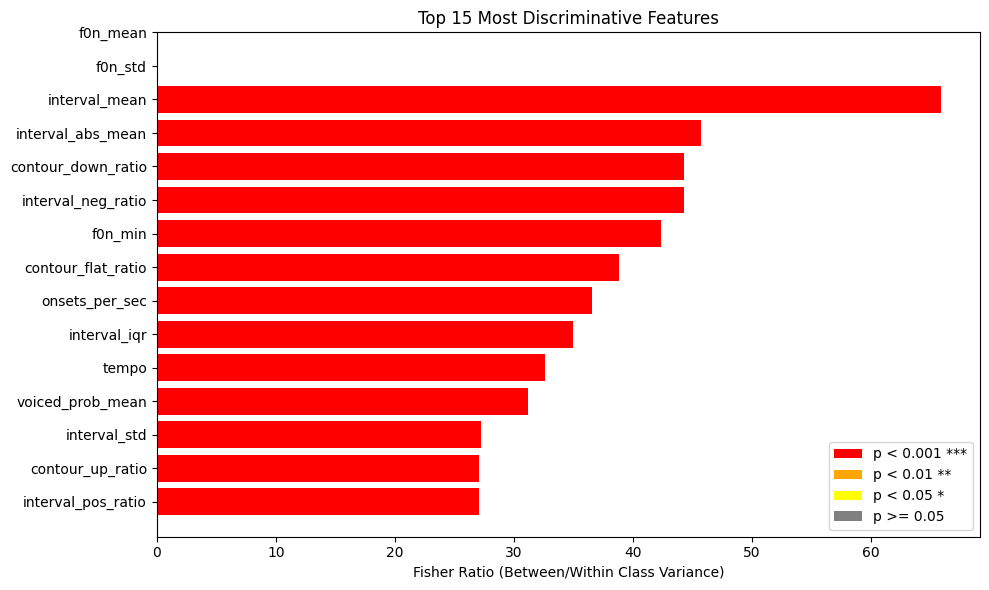

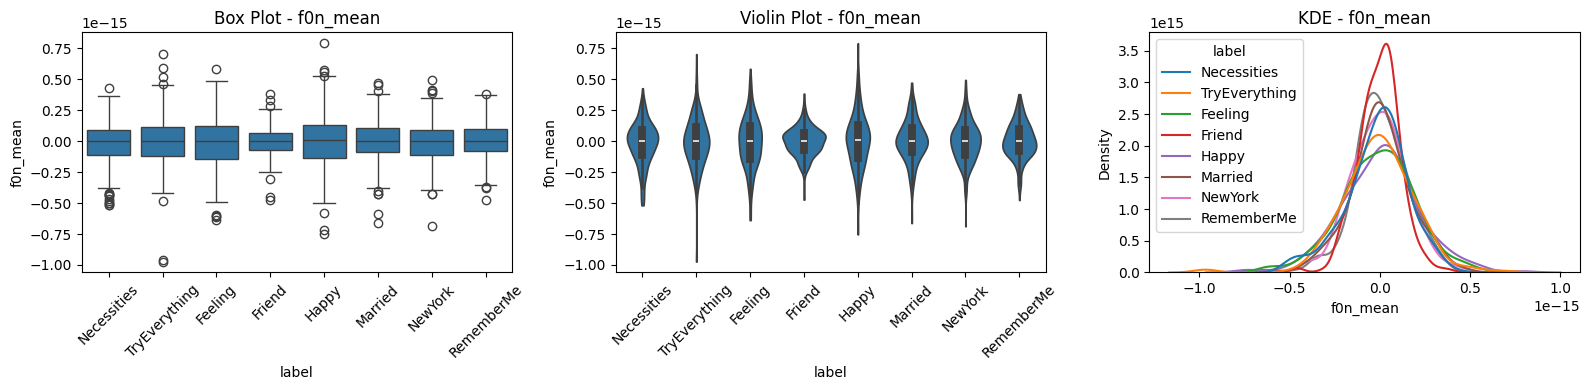

[warn] skip f0n_std: constant values


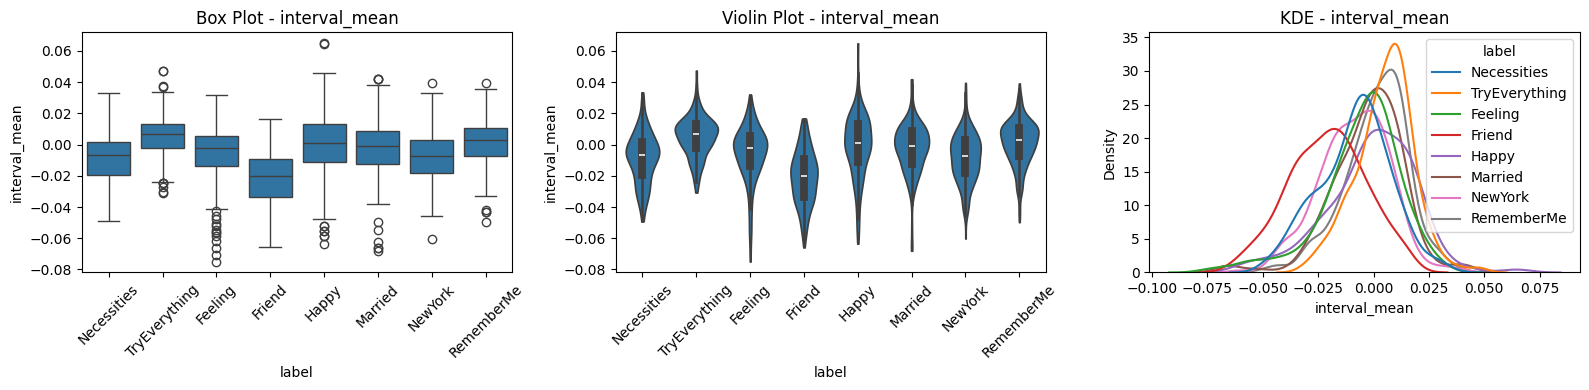

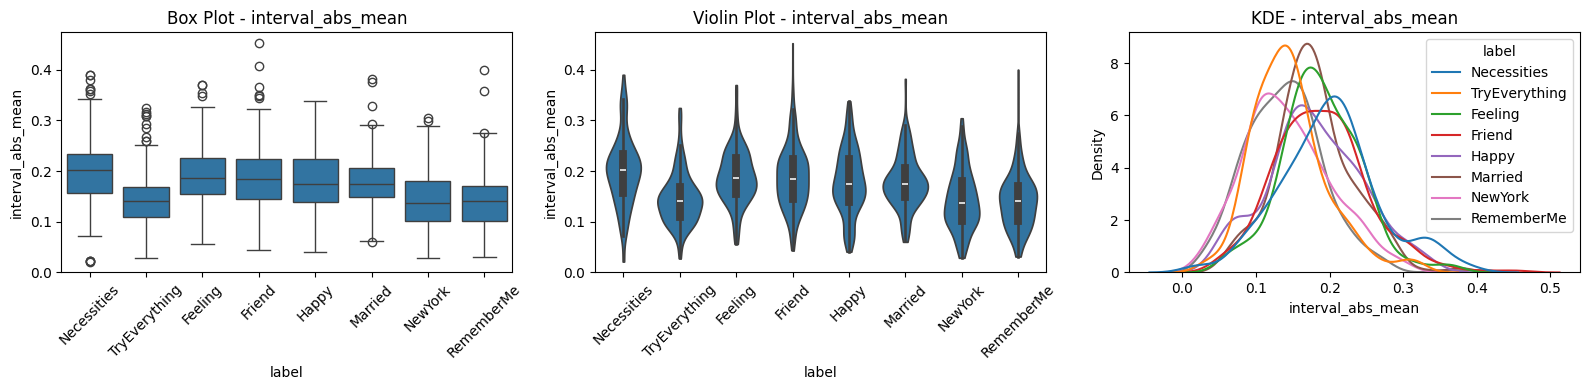

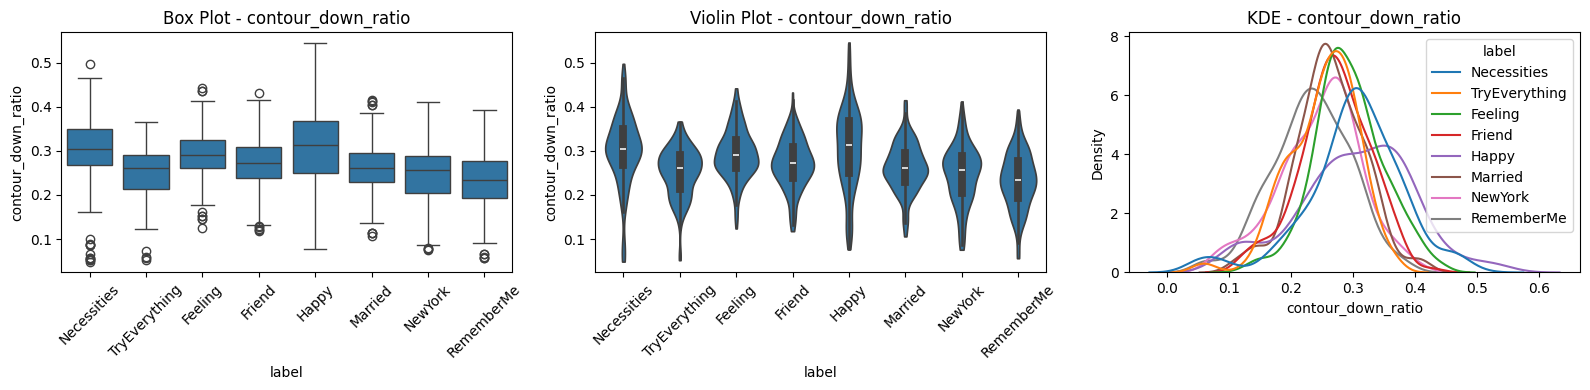

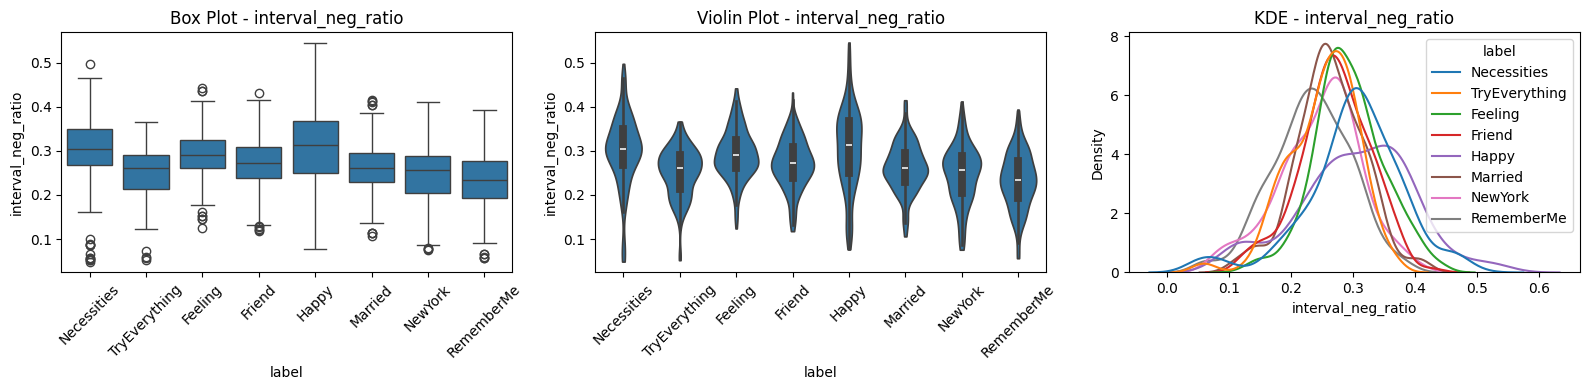

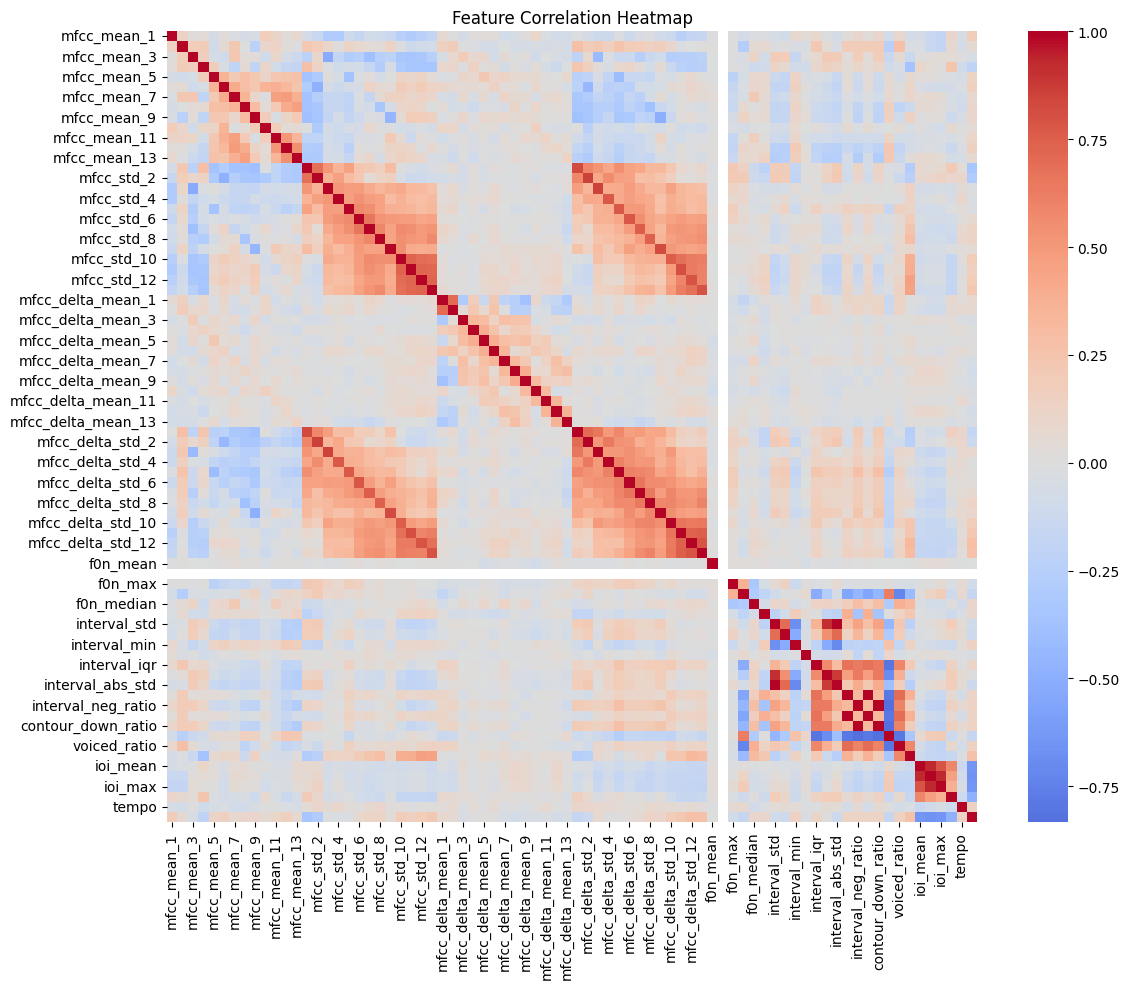

PCA Variance Explained: PC1=63.81%, PC2=18.11%, Total=81.92%


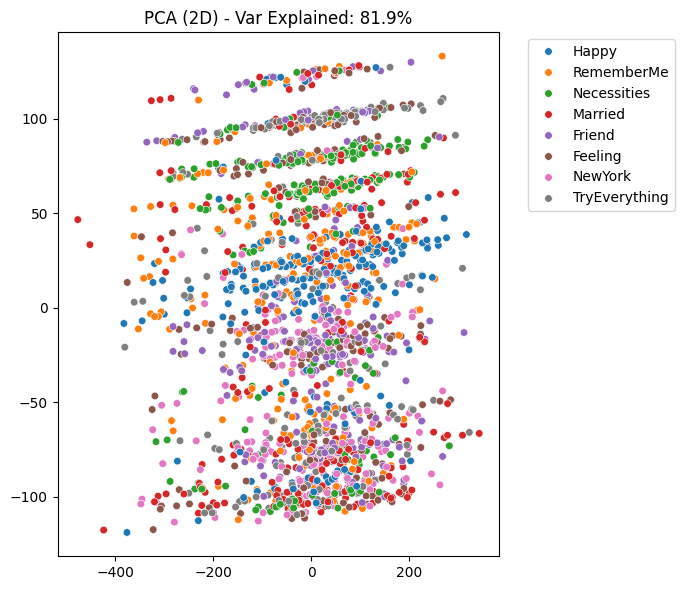

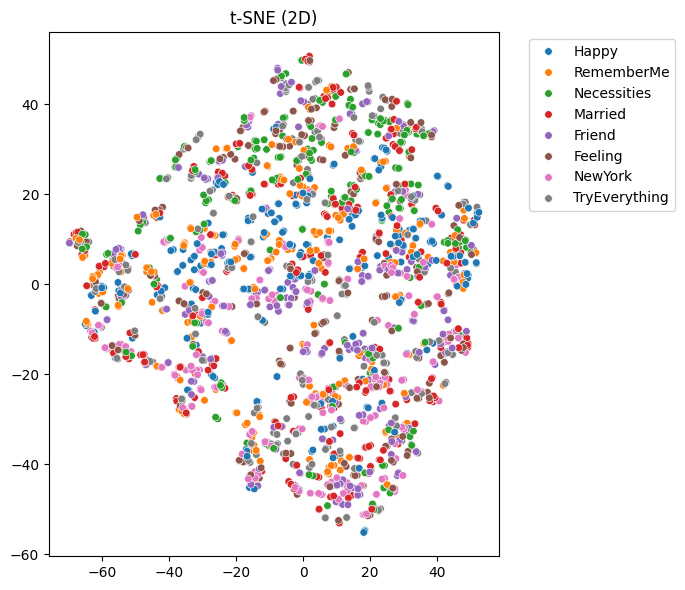


[Results saved to C:\Users\ASUS\Desktop\ML_Course\ML_Coursework\MyCourse\results\figures]
## Feature Analysis Results

### Feature Discriminative Power

| feature            |   fisher_ratio |       anova_p | significant   |
|:-------------------|---------------:|--------------:|:--------------|
| f0n_mean           |       inf      |   0.813821    |               |
| f0n_std            |       inf      | nan           |               |
| interval_mean      |        65.9064 |   1.2111e-86  | ***           |
| interval_abs_mean  |        45.7135 |   7.85436e-61 | ***           |
| contour_down_ratio |        44.3367 |   5.0258e-59  | ***           |
| interval_neg_ratio |        44.3367 |   5.0258e-59  | ***           |
| f0n_min            |        42.4085 |   1.74058e-56 | ***           |
| contour_flat_ratio |        38.8895 |   8.03352e-52 | ***           |
| onsets_per_sec     |        36.568  |   1.00662e-48 | ***           |
| interval_iqr       |        35.0033 |   1.25927e-46 

In [6]:
"""Notebook-friendly feature visualization utilities with EDA analysis.

This mirrors `visualize.py` but shows plots inline in a Jupyter notebook.
增强版：添加完整的EDA分析功能，输出数值结果和统计表格。
"""

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Dict, Any, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz path)
# ---------------------------------------------------------------------
DEFAULT_FEATURES = Path(
    "C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\splits\\train_full.npz"
)
DEFAULT_FIG_DIR = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\figures")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class VizConfig:
    max_points: int = 2000
    random_seed: int = 42
    tsne_perplexity: float = 30.0
    tsne_iter: int = 1000


# ---------------------------------------------------------------------
# 3) Data loading
# ---------------------------------------------------------------------
def load_features_npz(path: Path) -> pd.DataFrame:
    data = np.load(path, allow_pickle=True)
    features = data["X"]
    labels = data["labels"].astype(str)
    names = data["feature_names"].astype(str).tolist()
    df = pd.DataFrame(features, columns=names)
    df["label"] = labels
    return df


def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def _subset_df(df: pd.DataFrame, cfg: VizConfig) -> pd.DataFrame:
    if len(df) <= cfg.max_points:
        return df
    return df.sample(n=cfg.max_points, random_state=cfg.random_seed)


# ---------------------------------------------------------------------
# 4) EDA Analysis Functions (新增)
# ---------------------------------------------------------------------

def compute_basic_stats(df: pd.DataFrame) -> pd.DataFrame:
    """计算所有特征的基础统计量，返回汇总表格。
    
    Returns:
        DataFrame with columns: feature, count, missing, missing_pct, 
        mean, std, min, 25%, 50%, 75%, max, skewness, kurtosis
    """
    # 获取数值列（排除label）
    num_cols = [c for c in df.columns if c != "label"]
    
    records = []
    for col in num_cols:
        vals = df[col]
        missing = vals.isna().sum()
        valid = vals.dropna()
        
        records.append({
            "feature": col,
            "count": len(valid),
            "missing": missing,
            "missing_pct": f"{100 * missing / len(df):.2f}%",
            "mean": valid.mean(),
            "std": valid.std(),
            "min": valid.min(),
            "25%": valid.quantile(0.25),
            "50%": valid.quantile(0.50),
            "75%": valid.quantile(0.75),
            "max": valid.max(),
            "skewness": stats.skew(valid) if len(valid) > 2 else np.nan,
            "kurtosis": stats.kurtosis(valid) if len(valid) > 2 else np.nan,
        })
    
    return pd.DataFrame(records)


def compute_class_stats(df: pd.DataFrame) -> pd.DataFrame:
    """按类别计算每个特征的统计量。
    
    Returns:
        DataFrame with multi-level columns: (feature, statistic) for each class
    """
    num_cols = [c for c in df.columns if c != "label"]
    labels = df["label"].unique()
    
    records = []
    for col in num_cols:
        row = {"feature": col}
        for lab in sorted(labels):
            vals = df[df["label"] == lab][col].dropna()
            row[f"{lab}_mean"] = vals.mean()
            row[f"{lab}_std"] = vals.std()
            row[f"{lab}_count"] = len(vals)
        records.append(row)
    
    return pd.DataFrame(records)


def compute_feature_importance(df: pd.DataFrame) -> pd.DataFrame:
    """计算特征的区分能力指标。
    
    包含:
    - variance: 整体方差
    - between_class_var: 类间方差（越大越有区分力）
    - within_class_var: 类内方差
    - fisher_ratio: Fisher判别比 = 类间方差/类内方差
    - anova_f: ANOVA F统计量
    - anova_p: ANOVA p值
    """
    num_cols = [c for c in df.columns if c != "label"]
    labels = df["label"].unique()
    
    records = []
    for col in num_cols:
        vals = df[col].dropna()
        overall_mean = vals.mean()
        overall_var = vals.var()
        
        # 计算类间方差和类内方差
        between_var = 0.0
        within_var = 0.0
        groups = []
        
        for lab in labels:
            group_vals = df[df["label"] == lab][col].dropna()
            if len(group_vals) == 0:
                continue
            groups.append(group_vals.values)
            group_mean = group_vals.mean()
            group_var = group_vals.var()
            n = len(group_vals)
            
            between_var += n * (group_mean - overall_mean) ** 2
            within_var += (n - 1) * group_var if n > 1 else 0
        
        n_total = len(vals)
        k = len(labels)
        between_var /= (k - 1) if k > 1 else 1
        within_var /= (n_total - k) if n_total > k else 1
        
        fisher = between_var / within_var if within_var > 1e-10 else np.inf
        
        # ANOVA检验
        if len(groups) >= 2 and all(len(g) > 0 for g in groups):
            try:
                f_stat, p_val = stats.f_oneway(*groups)
            except:
                f_stat, p_val = np.nan, np.nan
        else:
            f_stat, p_val = np.nan, np.nan
        
        records.append({
            "feature": col,
            "variance": overall_var,
            "between_class_var": between_var,
            "within_class_var": within_var,
            "fisher_ratio": fisher,
            "anova_F": f_stat,
            "anova_p": p_val,
            "significant": "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
        })
    
    result = pd.DataFrame(records)
    # 按Fisher ratio排序，区分能力强的在前
    return result.sort_values("fisher_ratio", ascending=False).reset_index(drop=True)


def compute_correlation_pairs(df: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """找出高相关的特征对。
    
    Args:
        threshold: 相关系数阈值，默认0.7
    
    Returns:
        DataFrame with columns: feature1, feature2, correlation, abs_corr
    """
    num_df = df.drop(columns=["label"])
    corr = num_df.corr()
    
    pairs = []
    cols = corr.columns.tolist()
    for i, c1 in enumerate(cols):
        for c2 in cols[i+1:]:
            r = corr.loc[c1, c2]
            if abs(r) >= threshold:
                pairs.append({
                    "feature1": c1,
                    "feature2": c2,
                    "correlation": r,
                    "abs_corr": abs(r)
                })
    
    result = pd.DataFrame(pairs)
    if len(result) > 0:
        result = result.sort_values("abs_corr", ascending=False).reset_index(drop=True)
    return result


def detect_outliers(df: pd.DataFrame, method: str = "iqr", threshold: float = 1.5) -> pd.DataFrame:
    """检测每个特征的异常值数量。
    
    Args:
        method: 'iqr' (四分位距) 或 'zscore' (标准差)
        threshold: IQR倍数或Z-score阈值
    
    Returns:
        DataFrame with columns: feature, n_outliers, outlier_pct, range_info
    """
    num_cols = [c for c in df.columns if c != "label"]
    
    records = []
    for col in num_cols:
        vals = df[col].dropna()
        
        if method == "iqr":
            q1, q3 = vals.quantile(0.25), vals.quantile(0.75)
            iqr = q3 - q1
            lower, upper = q1 - threshold * iqr, q3 + threshold * iqr
            outliers = ((vals < lower) | (vals > upper)).sum()
            range_info = f"[{lower:.3g}, {upper:.3g}]"
        else:  # zscore
            z = np.abs(stats.zscore(vals))
            outliers = (z > threshold).sum()
            range_info = f"|z| > {threshold}"
        
        records.append({
            "feature": col,
            "n_outliers": outliers,
            "outlier_pct": f"{100 * outliers / len(vals):.2f}%",
            "valid_range": range_info
        })
    
    return pd.DataFrame(records).sort_values("n_outliers", ascending=False).reset_index(drop=True)


def compute_label_distribution(df: pd.DataFrame) -> pd.DataFrame:
    """计算标签分布。"""
    counts = df["label"].value_counts()
    total = len(df)
    
    records = []
    for lab, cnt in counts.items():
        records.append({
            "label": lab,
            "count": cnt,
            "percentage": f"{100 * cnt / total:.2f}%"
        })
    
    return pd.DataFrame(records)


def run_full_eda(df: pd.DataFrame, verbose: int = 1) -> Dict[str, pd.DataFrame]:
    """运行完整的EDA分析，返回所有结果表格。
    
    Args:
        df: 输入数据
        verbose: 输出详细程度 (0=静默, 1=精简, 2=详细)
    
    Returns:
        Dict containing all analysis results
    """
    results = {}
    
    # 计算所有结果
    results["label_dist"] = compute_label_distribution(df)
    results["basic_stats"] = compute_basic_stats(df)
    results["feature_importance"] = compute_feature_importance(df)
    results["class_stats"] = compute_class_stats(df)
    results["high_correlations"] = compute_correlation_pairs(df, threshold=0.7)
    results["outliers"] = detect_outliers(df, method="iqr", threshold=1.5)
    
    if verbose == 0:
        return results
    
    # === 核心输出 ===
    n_samples = len(df)
    n_features = len([c for c in df.columns if c != "label"])
    n_classes = df["label"].nunique()
    
    print("=" * 65)
    print("  EXPLORATORY DATA ANALYSIS REPORT")
    print("=" * 65)
    
    # 1. 数据概览（一行搞定）
    print(f"\n[Dataset] {n_samples} samples × {n_features} features × {n_classes} classes")
    print(f"[Labels]  {dict(zip(results['label_dist']['label'], results['label_dist']['count']))}")
    
    # 2. 特征区分能力（核心！按Fisher ratio排序）
    print("\n" + "-" * 65)
    print("  FEATURE RANKING (by discriminative power)")
    print("-" * 65)
    feat_imp = results["feature_importance"]
    # 精简显示：只显示关键列
    display_cols = ["feature", "fisher_ratio", "anova_p", "significant"]
    display_df = feat_imp[display_cols].copy()
    display_df["fisher_ratio"] = display_df["fisher_ratio"].apply(
        lambda x: f"{x:.3f}" if pd.notna(x) and not np.isinf(x) else "inf")
    display_df["anova_p"] = display_df["anova_p"].apply(
        lambda x: f"{x:.2e}" if pd.notna(x) else "NaN")
    print(display_df.to_string(index=False))
    
    # 3. 高相关特征对（只在有结果时显示）
    high_corr = results["high_correlations"]
    if len(high_corr) > 0:
        print("\n" + "-" * 65)
        print(f"  REDUNDANT FEATURES (|correlation| >= 0.7): {len(high_corr)} pairs")
        print("-" * 65)
        display_corr = high_corr[["feature1", "feature2", "correlation"]].head(10)
        display_corr["correlation"] = display_corr["correlation"].apply(lambda x: f"{x:.3f}")
        print(display_corr.to_string(index=False))
        if len(high_corr) > 10:
            print(f"  ... and {len(high_corr) - 10} more pairs")
    
    # 4. 数据质量警告（只在有问题时显示）
    basic_stats = results["basic_stats"]
    total_missing = basic_stats["missing"].sum()
    outliers = results["outliers"]
    high_outlier_feats = outliers[outliers["n_outliers"] > n_samples * 0.1]  # >10%异常值
    
    if total_missing > 0 or len(high_outlier_feats) > 0:
        print("\n" + "-" * 65)
        print("  DATA QUALITY WARNINGS")
        print("-" * 65)
        if total_missing > 0:
            missing_feats = basic_stats[basic_stats["missing"] > 0][["feature", "missing", "missing_pct"]]
            print(f"[Missing] {total_missing} values in {len(missing_feats)} features")
            if verbose >= 2:
                print(missing_feats.to_string(index=False))
        if len(high_outlier_feats) > 0:
            print(f"[Outliers] {len(high_outlier_feats)} features with >10% outliers:")
            for _, row in high_outlier_feats.head(5).iterrows():
                print(f"    {row['feature']}: {row['n_outliers']} ({row['outlier_pct']})")
    
    # 5. 结论摘要
    print("\n" + "=" * 65)
    print("  SUMMARY")
    print("=" * 65)
    top3 = feat_imp.head(3)
    weak = feat_imp[feat_imp["anova_p"] >= 0.05]
    print(f"  ✓ Top discriminative: {', '.join(top3['feature'].tolist())}")
    if len(weak) > 0:
        print(f"  ✗ Weak features (p>=0.05): {len(weak)} features may be removed")
    if len(high_corr) > 0:
        print(f"  ✗ Redundant pairs: {len(high_corr)} (consider removing one from each pair)")
    print("=" * 65)
    
    return results


def eda_to_markdown(results: Dict[str, pd.DataFrame], top_n: int = 10) -> str:
    """将EDA核心结果转换为Markdown格式（精简版）。"""
    md = ["## Feature Analysis Results\n"]
    
    # 特征排名（核心）
    md.append("### Feature Discriminative Power\n")
    imp = results["feature_importance"][["feature", "fisher_ratio", "anova_p", "significant"]].head(top_n)
    md.append(imp.to_markdown(index=False))
    md.append("\n")
    
    # 高相关（如果有）
    if len(results["high_correlations"]) > 0:
        md.append("### Redundant Features (|r| >= 0.7)\n")
        md.append(results["high_correlations"][["feature1", "feature2", "correlation"]].head(10).to_markdown(index=False))
        md.append("\n")
    
    return "\n".join(md)


# ---------------------------------------------------------------------
# 5) Plotting helpers (show inline + optional save) - 保持原有功能
# ---------------------------------------------------------------------
def _finish_plot(fig: plt.Figure, out_path: Path | None, show: bool) -> None:
    fig.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)


def plot_box_violin_kde(
    df: pd.DataFrame,
    features: Iterable[str],
    out_dir: Path | None = None,
    show: bool = True,
) -> None:
    if out_dir is not None:
        ensure_dir(out_dir)
    for feat in features:
        if feat not in df.columns:
            continue
        values = df[feat].to_numpy()
        if np.nanstd(values) == 0.0:
            print(f"[warn] skip {feat}: constant values")
            continue
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        sns.boxplot(data=df, x="label", y=feat, ax=axes[0])
        axes[0].set_title(f"Box Plot - {feat}")
        axes[0].tick_params(axis="x", rotation=45)

        sns.violinplot(data=df, x="label", y=feat, ax=axes[1], cut=0)
        axes[1].set_title(f"Violin Plot - {feat}")
        axes[1].tick_params(axis="x", rotation=45)

        sns.kdeplot(
            data=df,
            x=feat,
            hue="label",
            ax=axes[2],
            fill=False,
            common_norm=False,
            warn_singular=False,
        )
        axes[2].set_title(f"KDE - {feat}")

        out_path = out_dir / f"{feat}_dist.png" if out_dir is not None else None
        _finish_plot(fig, out_path, show)


def plot_corr_heatmap(
    df: pd.DataFrame, out_dir: Path | None = None, show: bool = True
) -> pd.DataFrame:
    """绘制相关性热力图，并返回相关矩阵。"""
    if out_dir is not None:
        ensure_dir(out_dir)
    corr = df.drop(columns=["label"]).corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0.0, ax=ax)
    ax.set_title("Feature Correlation Heatmap")
    out_path = out_dir / "correlation_heatmap.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)
    return corr  # 返回相关矩阵供后续使用


def plot_pca_tsne(
    df: pd.DataFrame,
    out_dir: Path | None = None,
    cfg: VizConfig | None = None,
    show: bool = True,
) -> Dict[str, Any]:
    """执行PCA和t-SNE，返回降维结果和解释信息。"""
    if out_dir is not None:
        ensure_dir(out_dir)
    cfg = cfg or VizConfig()
    df_sub = _subset_df(df, cfg)
    X = df_sub.drop(columns=["label"]).to_numpy()
    y = df_sub["label"].to_numpy()
    
    result = {"pca": None, "tsne": None, "pca_var_explained": None}
    
    if X.shape[0] < 2:
        print("[warn] skip PCA/t-SNE: not enough samples")
        return result
    std = np.nanstd(X, axis=0)
    keep = std > 1e-8
    if not np.any(keep):
        print("[warn] skip PCA/t-SNE: all features are constant")
        return result
    X = X[:, keep]
    if np.unique(X, axis=0).shape[0] < 2:
        print("[warn] skip PCA/t-SNE: only one unique sample")
        return result

    # PCA
    pca = PCA(n_components=2, random_state=cfg.random_seed)
    X_pca = pca.fit_transform(X)
    result["pca"] = X_pca
    result["pca_var_explained"] = pca.explained_variance_ratio_
    
    # 打印PCA方差解释
    print(f"PCA Variance Explained: PC1={pca.explained_variance_ratio_[0]:.2%}, "
          f"PC2={pca.explained_variance_ratio_[1]:.2%}, "
          f"Total={sum(pca.explained_variance_ratio_):.2%}")

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, s=30, ax=ax)
    ax.set_title(f"PCA (2D) - Var Explained: {sum(pca.explained_variance_ratio_):.1%}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    out_path = out_dir / "pca_2d.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)

    # t-SNE
    tsne_kwargs = dict(
        n_components=2,
        perplexity=cfg.tsne_perplexity,
        random_state=cfg.random_seed,
        init="pca",
        learning_rate="auto",
    )
    try:
        tsne = TSNE(max_iter=cfg.tsne_iter, **tsne_kwargs)
    except TypeError:
        tsne = TSNE(n_iter=cfg.tsne_iter, **tsne_kwargs)
    X_tsne = tsne.fit_transform(X)
    result["tsne"] = X_tsne
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, s=30, ax=ax)
    ax.set_title("t-SNE (2D)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    out_path = out_dir / "tsne_2d.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)
    
    return result


def plot_feature_importance_bar(df: pd.DataFrame, top_n: int = 15, 
                                 out_dir: Path | None = None, show: bool = True) -> pd.DataFrame:
    """绘制特征重要性条形图（按Fisher ratio排序）。"""
    if out_dir is not None:
        ensure_dir(out_dir)
    
    feat_imp = compute_feature_importance(df)
    top_features = feat_imp.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['red' if p < 0.001 else ('orange' if p < 0.01 else ('yellow' if p < 0.05 else 'gray'))
              for p in top_features["anova_p"]]
    
    bars = ax.barh(range(len(top_features)), top_features["fisher_ratio"], color=colors)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["feature"])
    ax.invert_yaxis()
    ax.set_xlabel("Fisher Ratio (Between/Within Class Variance)")
    ax.set_title(f"Top {top_n} Most Discriminative Features")
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='p < 0.001 ***'),
        Patch(facecolor='orange', label='p < 0.01 **'),
        Patch(facecolor='yellow', label='p < 0.05 *'),
        Patch(facecolor='gray', label='p >= 0.05'),
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    out_path = out_dir / "feature_importance.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)
    
    return feat_imp


def default_feature_list() -> List[str]:
    return [
        "interval_mean",
        "interval_std",
        "tempo",
        "ioi_std",
        "f0n_std",
        "mfcc_mean_1",
    ]


# ---------------------------------------------------------------------
# 6) Complete Analysis Pipeline (新增)
# ---------------------------------------------------------------------

def run_complete_analysis(
    df: pd.DataFrame,
    features: Iterable[str] | None = None,
    out_dir: Path | None = None,
    show: bool = True,
    cfg: VizConfig | None = None,
    verbose: int = 1,
) -> Dict[str, Any]:
    """运行完整的分析流程：EDA + 可视化。
    
    Args:
        df: 输入数据
        features: 要可视化的特征列表，None则自动选择top特征
        out_dir: 输出目录
        show: 是否显示图片
        cfg: 可视化配置
        verbose: 输出详细程度 (0=静默, 1=精简, 2=详细)
    
    Returns:
        Dict containing all analysis results
    """
    results = {}
    
    # 1. EDA分析（核心）
    eda_results = run_full_eda(df, verbose=verbose)
    results["eda_results"] = eda_results
    
    # 2. 可视化（如果需要）
    if show or out_dir is not None:
        if verbose >= 1:
            print("\n[Generating visualizations...]")
        
        # 自动选择top特征进行可视化
        if features is None:
            top_feats = eda_results["feature_importance"].head(6)["feature"].tolist()
            features = [f for f in top_feats if f in df.columns]
        
        # 特征重要性条形图
        results["feature_importance"] = plot_feature_importance_bar(
            df, top_n=15, out_dir=out_dir, show=show)
        
        # 分布图（只画top特征）
        plot_box_violin_kde(df, features, out_dir=out_dir, show=show)
        
        # 相关性热力图
        results["correlation_matrix"] = plot_corr_heatmap(df, out_dir=out_dir, show=show)
        
        # PCA/t-SNE
        results["pca_tsne_results"] = plot_pca_tsne(df, out_dir=out_dir, cfg=cfg, show=show)
    
    # 3. 保存结果
    if out_dir is not None:
        ensure_dir(out_dir)
        eda_results["basic_stats"].to_csv(out_dir / "eda_basic_stats.csv", index=False)
        eda_results["feature_importance"].to_csv(out_dir / "eda_feature_importance.csv", index=False)
        if len(eda_results["high_correlations"]) > 0:
            eda_results["high_correlations"].to_csv(out_dir / "eda_high_correlations.csv", index=False)
        if verbose >= 1:
            print(f"\n[Results saved to {out_dir}]")
    
    return results


# ---------------------------------------------------------------------
# 7) Example usage
# ---------------------------------------------------------------------
df = load_features_npz(DEFAULT_FEATURES)
eda_results = run_full_eda(df)
results = run_complete_analysis(df, out_dir=DEFAULT_FIG_DIR)
md = eda_to_markdown(eda_results)
print(md)


好的，基于你的EDA结果，这是精简报告：

---

## 特征工程分析报告

**数据概况**：2252样本 × 78特征 × 8类（各类别均衡，约272-292样本）

### 核心发现

**1. 最具区分力的特征（Top 10）**
- `interval_mean` (Fisher=65.9) - 音程均值，最强区分力
- `interval_abs_mean` (45.7) - 音程绝对值均值
- `contour_down_ratio` / `interval_neg_ratio` (44.3) - 下行轮廓比例
- `f0n_min` (42.4) - 基频最小值
- `contour_flat_ratio` (38.9) - 平坦轮廓比例
- `onsets_per_sec` (36.6) - 每秒起音数
- `tempo` (32.6) - 节奏速度

**2. 建议删除的特征**
- **弱特征（p≥0.05）**：13个，主要是 `mfcc_mean_1~6`, `mfcc_std_2~4` 等
- **冗余特征**：38对高相关（|r|≥0.7），建议删除：
  - `interval_neg_ratio`（与`contour_down_ratio`完全相同）
  - `interval_pos_ratio`（与`contour_up_ratio`完全相同）
  - `interval_abs_std`（与`interval_std`相关0.996）
  - `ioi_std`/`ioi_max`（与`ioi_mean`高度相关）

**3. 数据质量问题**
- `f0n_mean`/`f0n_std`：常量特征，Fisher=inf但p值不显著，**应删除**
- `f0n_max`：14.3%异常值
- `mfcc_delta_mean_1`：11.8%异常值

### 结论

保留约**50个有效特征**即可（删除13个弱特征 + 约15个冗余特征），PCA显示前两主成分解释**81.9%方差**，数据结构良好。

In [7]:
"""特征筛选脚本：删除弱特征和冗余特征。

基于EDA分析结果，自动筛选有效特征。
"""

from __future__ import annotations
from pathlib import Path
from typing import List, Set, Tuple
import numpy as np
import pandas as pd
from scipy import stats


# =====================================================================
# 配置
# =====================================================================
# 数据目录
DATA_DIR = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\splits")

# 数据集列表：(输入文件名, 输出文件名)
DATASETS = [
    ("train_full.npz", "train_selected.npz"),
    ("val.npz", "val_selected.npz"),
    ("test.npz", "test_selected.npz"),
]

# 筛选阈值（仅用train计算，其他数据集复用同样的特征列表）
P_VALUE_THRESHOLD = 0.05      # p值阈值，大于此值的特征视为弱特征
CORR_THRESHOLD = 0.7          # 相关性阈值，高于此值的特征对视为冗余


# =====================================================================
# 核心函数
# =====================================================================

def load_npz(path: Path) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """加载npz文件，返回 (X, labels, feature_names)"""
    data = np.load(path, allow_pickle=True)
    return data["X"], data["labels"], data["feature_names"].tolist()


def save_npz(path: Path, X: np.ndarray, labels: np.ndarray, feature_names: List[str]):
    """保存为npz格式"""
    path.parent.mkdir(parents=True, exist_ok=True)
    np.savez(path, X=X, labels=labels, feature_names=np.array(feature_names))
    print(f"[保存] {path}")


def find_weak_features(X: np.ndarray, labels: np.ndarray, 
                       feature_names: List[str], p_threshold: float) -> Set[str]:
    """找出弱特征（ANOVA p值 >= 阈值 或 常量特征）"""
    weak = set()
    unique_labels = np.unique(labels)
    
    for i, feat in enumerate(feature_names):
        col = X[:, i]
        
        # 检查常量特征
        if np.nanstd(col) < 1e-10:
            weak.add(feat)
            continue
        
        # ANOVA检验
        groups = [col[labels == lab] for lab in unique_labels]
        groups = [g[~np.isnan(g)] for g in groups]  # 去除NaN
        
        if any(len(g) == 0 for g in groups):
            weak.add(feat)
            continue
            
        try:
            _, p_val = stats.f_oneway(*groups)
            if pd.isna(p_val) or p_val >= p_threshold:
                weak.add(feat)
        except:
            weak.add(feat)
    
    return weak


def find_redundant_features(X: np.ndarray, feature_names: List[str],
                            corr_threshold: float, weak_features: Set[str]) -> Set[str]:
    """找出冗余特征（高相关对中保留区分力更强的那个）"""
    # 计算相关矩阵
    df = pd.DataFrame(X, columns=feature_names)
    corr = df.corr().abs()
    
    redundant = set()
    n = len(feature_names)
    
    for i in range(n):
        for j in range(i + 1, n):
            if corr.iloc[i, j] >= corr_threshold:
                f1, f2 = feature_names[i], feature_names[j]
                # 如果其中一个已经是弱特征，删它
                if f1 in weak_features and f2 not in weak_features:
                    redundant.add(f1)
                elif f2 in weak_features and f1 not in weak_features:
                    redundant.add(f2)
                # 否则删后面那个（保留先出现的）
                elif f2 not in redundant:
                    redundant.add(f2)
    
    return redundant


def select_features(X: np.ndarray, labels: np.ndarray, feature_names: List[str],
                    p_threshold: float = 0.05, corr_threshold: float = 0.7,
                    verbose: bool = True) -> Tuple[np.ndarray, List[str], dict]:
    """
    执行特征筛选，返回筛选后的数据。
    
    Returns:
        X_selected: 筛选后的特征矩阵
        selected_names: 保留的特征名
        info: 筛选信息字典
    """
    n_original = len(feature_names)
    
    # 1. 找弱特征
    weak = find_weak_features(X, labels, feature_names, p_threshold)
    
    # 2. 找冗余特征
    redundant = find_redundant_features(X, feature_names, corr_threshold, weak)
    
    # 3. 合并要删除的特征
    to_remove = weak | redundant
    
    # 4. 筛选
    keep_idx = [i for i, f in enumerate(feature_names) if f not in to_remove]
    X_selected = X[:, keep_idx]
    selected_names = [feature_names[i] for i in keep_idx]
    
    # 5. 输出信息
    info = {
        "n_original": n_original,
        "n_selected": len(selected_names),
        "n_removed": len(to_remove),
        "weak_features": sorted(weak),
        "redundant_features": sorted(redundant - weak),  # 纯冗余（不含弱特征）
        "selected_features": selected_names,
    }
    
    if verbose:
        print("=" * 60)
        print("  FEATURE SELECTION REPORT")
        print("=" * 60)
        print(f"\n[原始] {n_original} 个特征")
        print(f"[删除] {len(to_remove)} 个特征")
        print(f"  - 弱特征 (p>={p_threshold}): {len(weak)} 个")
        print(f"  - 冗余特征 (|r|>={corr_threshold}): {len(redundant - weak)} 个")
        print(f"[保留] {len(selected_names)} 个特征")
        
        print(f"\n--- 删除的弱特征 ({len(weak)}) ---")
        for f in sorted(weak):
            print(f"  {f}")
        
        print(f"\n--- 删除的冗余特征 ({len(redundant - weak)}) ---")
        for f in sorted(redundant - weak):
            print(f"  {f}")
        
        print("\n" + "=" * 60)
    
    return X_selected, selected_names, info


# =====================================================================
# 主函数
# =====================================================================

def apply_feature_selection(X: np.ndarray, feature_names: List[str], 
                            selected_names: List[str]) -> np.ndarray:
    """根据已选特征列表筛选数据"""
    keep_idx = [feature_names.index(f) for f in selected_names if f in feature_names]
    return X[:, keep_idx]


def main():
    data_dir = DATA_DIR
    
    # ========== 第一步：用train数据计算要保留的特征 ==========
    train_input = data_dir / DATASETS[0][0]
    print(f"[加载训练集] {train_input}")
    X_train, labels_train, feature_names = load_npz(train_input)
    print(f"  shape: {X_train.shape}")
    
    # 特征筛选（只用train计算）
    X_train_sel, selected_names, info = select_features(
        X_train, labels_train, feature_names,
        p_threshold=P_VALUE_THRESHOLD,
        corr_threshold=CORR_THRESHOLD,
        verbose=True
    )
    
    # 保存train
    train_output = data_dir / DATASETS[0][1]
    save_npz(train_output, X_train_sel, labels_train, selected_names)
    
    # ========== 第二步：将相同的特征筛选应用到val和test ==========
    for input_name, output_name in DATASETS[1:]:
        input_path = data_dir / input_name
        output_path = data_dir / output_name
        
        if not input_path.exists():
            print(f"[跳过] {input_path} 不存在")
            continue
        
        print(f"\n[处理] {input_name}")
        X, labels, names = load_npz(input_path)
        
        # 应用相同的特征选择
        X_sel = apply_feature_selection(X, names, selected_names)
        save_npz(output_path, X_sel, labels, selected_names)
        print(f"  {X.shape[1]} -> {X_sel.shape[1]} 特征")
    
    # ========== 总结 ==========
    print("\n" + "=" * 60)
    print("  ALL DONE")
    print("=" * 60)
    print(f"特征: {info['n_original']} -> {info['n_selected']}")
    print(f"输出文件:")
    for _, output_name in DATASETS:
        print(f"  - {data_dir / output_name}")


if __name__ == "__main__":
    main()

[加载训练集] C:\Users\ASUS\Desktop\ML_Course\ML_Coursework\MyCourse\results\splits\train_full.npz
  shape: (2252, 78)
  FEATURE SELECTION REPORT

[原始] 78 个特征
[删除] 37 个特征
  - 弱特征 (p>=0.05): 14 个
  - 冗余特征 (|r|>=0.7): 23 个
[保留] 41 个特征

--- 删除的弱特征 (14) ---
  f0n_mean
  f0n_std
  mfcc_delta_mean_11
  mfcc_delta_mean_13
  mfcc_delta_mean_4
  mfcc_mean_1
  mfcc_mean_11
  mfcc_mean_2
  mfcc_mean_4
  mfcc_mean_5
  mfcc_mean_6
  mfcc_std_2
  mfcc_std_3
  mfcc_std_4

--- 删除的冗余特征 (23) ---
  contour_down_ratio
  contour_flat_ratio
  contour_up_ratio
  interval_abs_mean
  interval_abs_std
  ioi_max
  ioi_std
  mfcc_delta_mean_2
  mfcc_delta_std_1
  mfcc_delta_std_10
  mfcc_delta_std_11
  mfcc_delta_std_12
  mfcc_delta_std_13
  mfcc_delta_std_2
  mfcc_delta_std_5
  mfcc_delta_std_6
  mfcc_delta_std_7
  mfcc_delta_std_8
  mfcc_delta_std_9
  mfcc_std_11
  mfcc_std_12
  mfcc_std_13
  voiced_ratio

[保存] C:\Users\ASUS\Desktop\ML_Course\ML_Coursework\MyCourse\results\splits\train_selected.npz

[处理] val.npz
[保存]

In [ ]:
###有监督分类训练代码

from __future__ import annotations

import json
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, Dataset
except Exception:
    torch = None

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover
    tqdm = None

import librosa

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz paths)
# ---------------------------------------------------------------------
DEFAULT_TRAIN = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/train_full.npz")
DEFAULT_VAL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/val.npz")
DEFAULT_OUT = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")
DEFAULT_MODEL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/final_model.pkl")
DEFAULT_MODEL_DIR = DEFAULT_MODEL.parent
DEFAULT_MODEL_PATHS = {
    "knn": DEFAULT_MODEL_DIR / "knn_model.pkl",
    "rf": DEFAULT_MODEL_DIR / "rf_model.pkl",
    "mlp": DEFAULT_MODEL_DIR / "mlp_model.pkl",
    "cnn": DEFAULT_MODEL_DIR / "cnn_model.pkl",
    "final": DEFAULT_MODEL,
}


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class TrainConfig:
    n_splits: int = 5
    random_seed: int = 42


@dataclass
class MLPStableConfig:
    hidden_layer_sizes: Tuple[int, int] = (128, 64)
    alpha: float = 1e-3
    lr: float = 1e-3
    epochs: int = 200


# ---------------------------------------------------------------------
# 3) Loading + logging
# ---------------------------------------------------------------------
def load_features(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    paths = data["paths"].astype(str)
    return X, y, paths


def log_feature_stats(name: str, X: np.ndarray) -> None:
    finite_mask = np.isfinite(X)
    finite_ratio = float(np.mean(finite_mask))
    print(
        f"[{name}] shape={X.shape} finite={finite_ratio:.3f} "
        f"min={np.nanmin(X):.4f} max={np.nanmax(X):.4f}"
    )


def log_label_stats(name: str, y: np.ndarray) -> None:
    unique, counts = np.unique(y, return_counts=True)
    dist = ", ".join([f"{u}:{c}" for u, c in zip(unique, counts)])
    print(f"[{name}] samples={len(y)} classes={len(unique)} dist={{ {dist} }}")


# ---------------------------------------------------------------------
# 4) Preprocessing helpers
# ---------------------------------------------------------------------
def sanitize_features(
    X_train: np.ndarray, X_val: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    low = np.percentile(X_train, 1, axis=0)
    high = np.percentile(X_train, 99, axis=0)
    X_train = np.clip(X_train, low, high)
    X_val = np.clip(X_val, low, high)
    return X_train, X_val


def compute_clip_bounds(
    X: np.ndarray, low_q: float = 1.0, high_q: float = 99.0
) -> Tuple[np.ndarray, np.ndarray]:
    low = np.percentile(X, low_q, axis=0)
    high = np.percentile(X, high_q, axis=0)
    return low, high


def apply_clip(X: np.ndarray, low: np.ndarray, high: np.ndarray) -> np.ndarray:
    return np.clip(X, low, high)


def preprocess_mlp(
    X_train: np.ndarray, X_val: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, StandardScaler, Tuple[np.ndarray, np.ndarray]]:
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)
    low, high = compute_clip_bounds(X_train, low_q=1.0, high_q=99.0)
    X_train = apply_clip(X_train, low, high)
    X_val = apply_clip(X_val, low, high)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = np.clip(X_train, -3.0, 3.0)
    X_val = np.clip(X_val, -3.0, 3.0)
    return X_train, X_val, scaler, (low, high)


# ---------------------------------------------------------------------
# 5) Metrics
# ---------------------------------------------------------------------
def macro_auc(y_true: np.ndarray, y_proba: np.ndarray, classes: List[int]) -> float:
    try:
        return float(
            roc_auc_score(
                y_true,
                y_proba,
                multi_class="ovr",
                average="macro",
                labels=classes,
            )
        )
    except Exception:
        return float("nan")


def evaluate_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray
) -> Dict[str, float]:
    classes = sorted(np.unique(y_true).tolist())
    return {
        "macro_auc": macro_auc(y_true, y_proba, classes),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
    }


# ---------------------------------------------------------------------
# 6) CV search
# ---------------------------------------------------------------------
def cv_score(
    build_model: Any,
    param_grid: List[Dict[str, Any]],
    X: np.ndarray,
    y: np.ndarray,
    cfg: TrainConfig,
) -> Tuple[Dict[str, Any], float, int]:
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_seed)
    best_params: Dict[str, Any] = {}
    best_score = -np.inf
    failed_folds = 0
    iterator = tqdm(param_grid, desc="CV params", unit="cfg") if tqdm else param_grid
    for params in iterator:
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            model = build_model(params)
            try:
                model.fit(X[train_idx], y[train_idx])
                y_proba = model.predict_proba(X[val_idx])
                score = macro_auc(y[val_idx], y_proba, sorted(np.unique(y).tolist()))
                if not np.isnan(score):
                    scores.append(score)
            except ValueError:
                failed_folds += 1
                continue
        mean_score = float(np.mean(scores)) if scores else float("-inf")
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    return best_params, best_score, failed_folds


def build_knn(params: Dict[str, Any]) -> Pipeline:
    return Pipeline(
        [
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(**params)),
        ]
    )


def build_rf(params: Dict[str, Any]) -> RandomForestClassifier:
    return RandomForestClassifier(random_state=42, **params)


def train_mlp_stable(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    cfg: MLPStableConfig,
) -> Tuple[MLPClassifier, Dict[str, float]]:
    model = MLPClassifier(
        hidden_layer_sizes=cfg.hidden_layer_sizes,
        solver="adam",
        activation="relu",
        learning_rate_init=cfg.lr,
        learning_rate="adaptive",
        alpha=cfg.alpha,
        max_iter=cfg.epochs,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)
    y_pred = np.argmax(y_proba, axis=1)
    metrics = evaluate_metrics(y_val, y_pred, y_proba)
    return model, metrics


# ---------------------------------------------------------------------
# 7) CNN utilities (optional)
# ---------------------------------------------------------------------
class MFCCDataset(Dataset):
    def __init__(
        self,
        paths: List[str],
        labels: np.ndarray,
        label_encoder: LabelEncoder,
        sr: int,
        n_mfcc: int,
    ):
        self.paths = paths
        self.labels = label_encoder.transform(labels)
        self.sr = sr
        self.n_mfcc = n_mfcc

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        path = self.paths[idx]
        y, _ = librosa.load(path, sr=self.sr, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfcc.astype(np.float32), int(self.labels[idx])


class SimpleCNN(nn.Module):
    def __init__(self, n_mfcc: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_mfcc, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
        )
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        x = x.squeeze(-1)
        return self.fc(x)


def collate_pad(batch: List[Tuple[np.ndarray, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    lengths = [b[0].shape[1] for b in batch]
    max_len = max(lengths)
    n_mfcc = batch[0][0].shape[0]
    padded = np.zeros((len(batch), n_mfcc, max_len), dtype=np.float32)
    labels = np.zeros(len(batch), dtype=np.int64)
    for i, (mfcc, label) in enumerate(batch):
        padded[i, :, : mfcc.shape[1]] = mfcc
        labels[i] = label
    return torch.from_numpy(padded), torch.from_numpy(labels)


def train_cnn(
    train_paths: List[str],
    train_labels: np.ndarray,
    val_paths: List[str],
    val_labels: np.ndarray,
    label_encoder: LabelEncoder,
    epochs: int = 20,
    batch_size: int = 16,
    lr: float = 1e-3,
    device: str = "cpu",
) -> Tuple[Dict[str, float], Dict[str, Any]]:
    if torch is None:
        raise RuntimeError("PyTorch is required for CNN training.")

    n_mfcc = 13
    n_classes = len(label_encoder.classes_)
    train_ds = MFCCDataset(train_paths, train_labels, label_encoder, sr=22050, n_mfcc=n_mfcc)
    val_ds = MFCCDataset(val_paths, val_labels, label_encoder, sr=22050, n_mfcc=n_mfcc)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)

    model = SimpleCNN(n_mfcc=n_mfcc, n_classes=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        batch_iter = train_loader
        if tqdm:
            batch_iter = tqdm(
                train_loader,
                desc=f"CNN train {epoch}/{epochs}",
                unit="batch",
                leave=False,
            )
        for xb, yb in batch_iter:
            xb = xb.to(device)
            yb = yb.to(device)
            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

    model.eval()
    all_probs = []
    all_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_true.append(yb.numpy())

    y_true = np.concatenate(all_true)
    y_proba = np.vstack(all_probs)
    y_pred = np.argmax(y_proba, axis=1)
    metrics = evaluate_metrics(y_true, y_pred, y_proba)
    return metrics, {"model": model, "label_encoder": label_encoder}


def filter_existing_audio(paths: np.ndarray, labels: np.ndarray) -> Tuple[List[str], np.ndarray]:
    out_paths: List[str] = []
    out_labels: List[str] = []
    for p, y in zip(paths, labels):
        if "::" in p:
            continue
        if Path(p).is_file():
            out_paths.append(p)
            out_labels.append(y)
    return out_paths, np.asarray(out_labels)


def save_payload(payload: Dict[str, Any], path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    dump(payload, path)


def retrain_and_save_sklearn_models(
    results: Dict[str, Any],
    X_train: np.ndarray,
    X_val: np.ndarray,
    y_train_enc: np.ndarray,
    y_val_enc: np.ndarray,
    label_encoder: LabelEncoder,
    mlp_cfg: MLPStableConfig,
    model_paths: Dict[str, Path] | None = None,
) -> Dict[str, Path]:
    paths = model_paths or DEFAULT_MODEL_PATHS
    saved: Dict[str, Path] = {}
    X_full = np.vstack([X_train, X_val])
    y_full = np.concatenate([y_train_enc, y_val_enc])

    if "knn" in results and "best_params" in results["knn"]:
        model = build_knn(results["knn"]["best_params"])
        model.fit(X_full, y_full)
        save_payload({"model": model, "label_encoder": label_encoder}, paths["knn"])
        saved["knn"] = paths["knn"]

    if "rf" in results and "best_params" in results["rf"]:
        model = build_rf(results["rf"]["best_params"])
        model.fit(X_full, y_full)
        save_payload({"model": model, "label_encoder": label_encoder}, paths["rf"])
        saved["rf"] = paths["rf"]

    if "mlp" in results and "config" in results["mlp"]:
        X_full_mlp, _, mlp_scaler, clip_bounds = preprocess_mlp(X_full, X_full)
        model = MLPClassifier(
            hidden_layer_sizes=mlp_cfg.hidden_layer_sizes,
            solver="adam",
            activation="relu",
            learning_rate_init=mlp_cfg.lr,
            learning_rate="adaptive",
            alpha=mlp_cfg.alpha,
            max_iter=mlp_cfg.epochs,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42,
        )
        model.fit(X_full_mlp, y_full)
        payload = {
            "model": model,
            "label_encoder": label_encoder,
            "scaler": mlp_scaler,
            "clip_bounds": clip_bounds,
        }
        save_payload(payload, paths["mlp"])
        saved["mlp"] = paths["mlp"]

    return saved


def save_cnn_artifacts(
    cnn_artifacts: Dict[str, Any] | None, model_paths: Dict[str, Path] | None = None
) -> Path | None:
    if cnn_artifacts is None:
        return None
    paths = model_paths or DEFAULT_MODEL_PATHS
    save_payload(cnn_artifacts, paths["cnn"])
    return paths["cnn"]

In [ ]:
"""训练脚本：KNN + RF + MLP + DeepMLP (PyTorch)

修复问题：
1. MLP预处理逻辑修复（先计算clip边界再clip）
2. 用PyTorch DeepMLP替换CNN（CNN不适合手工特征）
"""

from __future__ import annotations

import json
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional

import numpy as np
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# PyTorch（可选）
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False
    torch = None

# tqdm（可选）
try:
    from tqdm import tqdm
except ImportError:
    tqdm = None

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# =====================================================================
# 配置
# =====================================================================
@dataclass
class TrainConfig:
    # 数据路径
    train_path: Path = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\splits\\train_selected.npz")
    val_path: Path = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\splits\\val_selected.npz")
    test_path: Path = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\splits\\test_selected.npz")
    
    # 输出路径
    out_dir: Path = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\results\\training")
    model_dir: Path = Path("C:\\Users\\ASUS\\Desktop\\ML_Course\\ML_Coursework\\MyCourse\\models")
    
    # 交叉验证
    n_splits: int = 5
    random_seed: int = 42
    
    # 是否包含各模型
    include_knn: bool = True
    include_rf: bool = True
    include_mlp: bool = True
    include_deep: bool = True  # PyTorch DeepMLP


@dataclass
class MLPConfig:
    """sklearn MLP配置"""
    hidden_layer_sizes: Tuple[int, ...] = (128, 64)
    alpha: float = 1e-3        # L2正则化
    lr: float = 1e-3           # 学习率
    max_iter: int = 300        # 最大迭代次数


@dataclass
class DeepMLPConfig:
    """PyTorch DeepMLP配置"""
    hidden_sizes: List[int] = field(default_factory=lambda: [256, 128, 64])
    dropout: float = 0.3
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 100
    batch_size: int = 64
    patience: int = 15         # 早停patience


# =====================================================================
# 数据加载与预处理
# =====================================================================

def load_npz(path: Path) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """加载npz文件"""
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    names = data["feature_names"].tolist() if "feature_names" in data else []
    return X, y, names


def sanitize_features(X: np.ndarray) -> np.ndarray:
    """处理NaN和Inf"""
    return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)


def preprocess_for_mlp(
    X_train: np.ndarray, 
    X_val: np.ndarray,
    X_test: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray], StandardScaler, Tuple]:
    """MLP预处理：clip + 标准化（修复版）
    
    关键修复：先在原始数据上计算clip边界，再应用clip
    """
    # Step 1: 处理NaN/Inf
    X_train = sanitize_features(X_train)
    X_val = sanitize_features(X_val)
    if X_test is not None:
        X_test = sanitize_features(X_test)
    
    # Step 2: 基于原始训练集计算clip边界（1-99百分位）
    clip_low = np.percentile(X_train, 1, axis=0)
    clip_high = np.percentile(X_train, 99, axis=0)
    
    # Step 3: 应用clip
    X_train = np.clip(X_train, clip_low, clip_high)
    X_val = np.clip(X_val, clip_low, clip_high)
    if X_test is not None:
        X_test = np.clip(X_test, clip_low, clip_high)
    
    # Step 4: 标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    if X_test is not None:
        X_test = scaler.transform(X_test)
    
    # Step 5: 标准化后再clip到[-5, 5]防止极端值
    X_train = np.clip(X_train, -5.0, 5.0)
    X_val = np.clip(X_val, -5.0, 5.0)
    if X_test is not None:
        X_test = np.clip(X_test, -5.0, 5.0)
    
    clip_bounds = (clip_low, clip_high)
    return X_train, X_val, X_test, scaler, clip_bounds


# =====================================================================
# 评估指标
# =====================================================================

def evaluate(y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray) -> Dict[str, float]:
    """计算评估指标"""
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
    }
    
    # Macro AUC（OvR）
    try:
        if y_proba.shape[1] == 2:
            metrics["macro_auc"] = roc_auc_score(y_true, y_proba[:, 1])
        else:
            metrics["macro_auc"] = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    except ValueError:
        metrics["macro_auc"] = float("nan")
    
    return metrics


# =====================================================================
# 模型构建
# =====================================================================

def build_knn(params: Dict) -> KNeighborsClassifier:
    return KNeighborsClassifier(**params)


def build_rf(params: Dict) -> RandomForestClassifier:
    return RandomForestClassifier(**params, random_state=42, n_jobs=-1)


def build_mlp(cfg: MLPConfig) -> MLPClassifier:
    return MLPClassifier(
        hidden_layer_sizes=cfg.hidden_layer_sizes,
        solver="adam",
        activation="relu",
        learning_rate_init=cfg.lr,
        learning_rate="adaptive",
        alpha=cfg.alpha,
        max_iter=cfg.max_iter,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        random_state=42,
    )


# =====================================================================
# PyTorch DeepMLP
# =====================================================================

class DeepMLP(nn.Module):
    """更深的MLP网络，带BatchNorm和Dropout"""
    
    def __init__(self, input_dim: int, hidden_sizes: List[int], num_classes: int, dropout: float = 0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for h in hidden_sizes:
            layers.extend([
                nn.Linear(prev_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout),
            ])
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)


def train_deep_mlp(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    cfg: DeepMLPConfig,
) -> Tuple[nn.Module, Dict[str, Any]]:
    """训练PyTorch DeepMLP"""
    
    if not HAS_TORCH:
        raise RuntimeError("PyTorch未安装")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 数据转换
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.LongTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.LongTensor(y_val)
    
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    
    # 模型
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = DeepMLP(input_dim, cfg.hidden_sizes, num_classes, cfg.dropout).to(device)
    
    # 优化器和损失
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()
    
    # 训练循环
    best_auc = 0.0
    best_state = None
    patience_counter = 0
    history = {"train_loss": [], "val_auc": [], "val_acc": []}
    
    iterator = range(cfg.epochs)
    if tqdm is not None:
        iterator = tqdm(iterator, desc="DeepMLP", unit="ep")
    
    for epoch in iterator:
        # 训练
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_loss)
        
        # 验证
        model.eval()
        with torch.no_grad():
            logits = model(X_val_t.to(device))
            proba = torch.softmax(logits, dim=1).cpu().numpy()
            pred = np.argmax(proba, axis=1)
        
        metrics = evaluate(y_val, pred, proba)
        history["val_auc"].append(metrics["macro_auc"])
        history["val_acc"].append(metrics["accuracy"])
        
        scheduler.step(metrics["macro_auc"])
        
        # 早停
        if metrics["macro_auc"] > best_auc:
            best_auc = metrics["macro_auc"]
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= cfg.patience:
            if tqdm is not None:
                iterator.set_postfix({"early_stop": epoch})
            break
        
        if tqdm is not None:
            iterator.set_postfix({"loss": f"{avg_loss:.4f}", "auc": f"{metrics['macro_auc']:.4f}"})
    
    # 加载最佳模型
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, {"history": history, "best_auc": best_auc}


# =====================================================================
# 交叉验证
# =====================================================================

def cv_search(
    builder_fn,
    param_grid: List[Dict],
    X: np.ndarray,
    y: np.ndarray,
    cfg: TrainConfig,
) -> Tuple[Dict, float]:
    """网格搜索 + 交叉验证（用于原始特征模型：KNN/RF）"""
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_seed)

    best_params = None
    best_score = -1.0

    for params in param_grid:
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_vl = X[train_idx], X[val_idx]
            y_tr, y_vl = y[train_idx], y[val_idx]

            try:
                model = builder_fn(params)
                model.fit(X_tr, y_tr)
                y_proba = model.predict_proba(X_vl)
                y_pred = np.argmax(y_proba, axis=1)
                m = evaluate(y_vl, y_pred, y_proba)
                scores.append(m["macro_auc"])
            except Exception:
                scores.append(0.0)

        mean_score = np.nanmean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    return best_params, best_score


def cv_search_mlp(
    param_grid: List[Dict],
    X: np.ndarray,
    y: np.ndarray,
    cfg: TrainConfig,
) -> Tuple[Dict, float]:
    """sklearn MLP的5折CV，按折进行独立预处理以避免泄漏"""
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_seed)

    best_params = None
    best_score = -1.0

    for params in param_grid:
        # 将参数映射到MLPConfig（未给出则使用默认）
        mlp_cfg = MLPConfig(
            hidden_layer_sizes=params.get("hidden_layer_sizes", (128, 64)),
            alpha=params.get("alpha", 1e-3),
            lr=params.get("lr", 1e-3),
            max_iter=params.get("max_iter", 300),
        )

        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_vl = X[train_idx], X[val_idx]
            y_tr, y_vl = y[train_idx], y[val_idx]

            # 每折独立预处理
            X_tr_nn, X_vl_nn, _, _, _ = preprocess_for_mlp(X_tr, X_vl)

            try:
                model = build_mlp(mlp_cfg)
                model.fit(X_tr_nn, y_tr)
                y_proba = model.predict_proba(X_vl_nn)
                y_pred = np.argmax(y_proba, axis=1)
                m = evaluate(y_vl, y_pred, y_proba)
                scores.append(m.get("macro_auc", 0.0))
            except Exception:
                scores.append(0.0)

        mean_score = np.nanmean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = {
                "hidden_layer_sizes": mlp_cfg.hidden_layer_sizes,
                "alpha": mlp_cfg.alpha,
                "lr": mlp_cfg.lr,
                "max_iter": mlp_cfg.max_iter,
            }

    return best_params, best_score


def cv_search_deep(
    param_grid: List[Dict],
    X: np.ndarray,
    y: np.ndarray,
    cfg: TrainConfig,
) -> Tuple[Dict, float]:
    """PyTorch DeepMLP的5折CV，按折进行独立预处理以避免泄漏"""
    if not HAS_TORCH:
        raise RuntimeError("PyTorch未安装，无法进行DeepMLP CV")

    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_seed)

    best_params = None
    best_score = -1.0

    for params in param_grid:
        # 将参数映射到DeepMLPConfig
        deep_cfg = DeepMLPConfig(
            hidden_sizes=params.get("hidden_sizes", [256, 128, 64]),
            dropout=params.get("dropout", 0.3),
            lr=params.get("lr", 1e-3),
            weight_decay=params.get("weight_decay", 1e-4),
            epochs=params.get("epochs", 60),
            batch_size=params.get("batch_size", 64),
            patience=params.get("patience", 10),
        )

        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_vl = X[train_idx], X[val_idx]
            y_tr, y_vl = y[train_idx], y[val_idx]

            # 每折独立预处理
            X_tr_nn, X_vl_nn, _, _, _ = preprocess_for_mlp(X_tr, X_vl)

            try:
                model, _ = train_deep_mlp(X_tr_nn, y_tr, X_vl_nn, y_vl, deep_cfg)
                model.eval()
                device = next(model.parameters()).device
                with torch.no_grad():
                    X_vl_t = torch.FloatTensor(X_vl_nn).to(device)
                    logits = model(X_vl_t)
                    y_proba = torch.softmax(logits, dim=1).cpu().numpy()
                    y_pred = np.argmax(y_proba, axis=1)
                m = evaluate(y_vl, y_pred, y_proba)
                scores.append(m.get("macro_auc", 0.0))
            except Exception:
                scores.append(0.0)

        mean_score = np.nanmean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = {
                "hidden_sizes": deep_cfg.hidden_sizes,
                "dropout": deep_cfg.dropout,
                "lr": deep_cfg.lr,
                "weight_decay": deep_cfg.weight_decay,
                "epochs": deep_cfg.epochs,
                "batch_size": deep_cfg.batch_size,
                "patience": deep_cfg.patience,
            }

    return best_params, best_score


# =====================================================================
# 主训练流程
# =====================================================================

def train_all(cfg: TrainConfig) -> Dict[str, Any]:
    """训练所有模型"""
    
    results = {}
    
    # ========== 加载数据 ==========
    print("=" * 60)
    print("  LOADING DATA (train + val for CV)")
    print("=" * 60)
    
    X_train, y_train, feat_names = load_npz(cfg.train_path)
    X_val, y_val, _ = load_npz(cfg.val_path)
    
    print(f"[Train] {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"[Val]   {X_val.shape[0]} samples")

    # 合并训练与验证用于CV
    X_full = np.concatenate([X_train, X_val], axis=0)
    y_full = np.concatenate([y_train, y_val], axis=0)
    
    # 标签编码
    le = LabelEncoder()
    le.fit(y_full)
    y_train_enc = le.transform(y_train)
    y_val_enc = le.transform(y_val)
    y_full_enc = le.transform(y_full)
    
    print(f"[Classes] {le.classes_.tolist()}")
    
    # 预处理（用于最终训练 MLP 和 DeepMLP）将在选参后对全量数据进行
    
    # 确保模型保存目录存在
    cfg.model_dir.mkdir(parents=True, exist_ok=True)
    
    # 超参网格
    knn_grid = [{"n_neighbors": k, "weights": w} for k in [3, 5, 7, 9] for w in ["uniform", "distance"]]
    rf_grid = [{"n_estimators": n, "max_depth": d} for n in [100, 200] for d in [5, 10, None]]
    mlp_grid = [
        {"hidden_layer_sizes": (128, 64), "alpha": 1e-3, "lr": 1e-3},
        {"hidden_layer_sizes": (256, 128), "alpha": 1e-4, "lr": 1e-3},
        {"hidden_layer_sizes": (128, 64, 32), "alpha": 1e-3, "lr": 1e-3},
    ]
    deep_grid = [
        {"hidden_sizes": [256, 128, 64], "dropout": 0.3, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 60, "batch_size": 64, "patience": 10},
        {"hidden_sizes": [128, 64], "dropout": 0.3, "lr": 5e-4, "weight_decay": 5e-5, "epochs": 80, "batch_size": 64, "patience": 10},
    ]
    
    # ========== KNN ==========
    if cfg.include_knn:
        print("\n" + "-" * 60)
        print("  CV Selecting KNN params (5-fold)")
        print("-" * 60)
        
        best_params, cv_auc = cv_search(build_knn, knn_grid, X_full, y_full_enc, cfg)
        
        # 用全部数据训练最终模型
        model = build_knn(best_params)
        model.fit(X_full, y_full_enc)
        
        results["knn"] = {
            "best_params": best_params,
            "cv_auc": cv_auc,
            "final_model_trained": True,
        }
        print(f"  params: {best_params}")
        print(f"  cv_auc={cv_auc:.4f}")
        # 保存模型
        try:
            knn_path = cfg.model_dir / "knn.pkl"
            dump(model, knn_path)
            print(f"  [保存模型] {knn_path}")
        except Exception as e:
            print(f"  [保存失败] KNN: {e}")
    
    # ========== Random Forest ==========
    if cfg.include_rf:
        print("\n" + "-" * 60)
        print("  CV Selecting Random Forest params (5-fold)")
        print("-" * 60)
        
        best_params, cv_auc = cv_search(build_rf, rf_grid, X_full, y_full_enc, cfg)
        
        # 用全部数据训练最终模型
        model = build_rf(best_params)
        model.fit(X_full, y_full_enc)
        
        results["rf"] = {
            "best_params": best_params,
            "cv_auc": cv_auc,
            "final_model_trained": True,
        }
        print(f"  params: {best_params}")
        print(f"  cv_auc={cv_auc:.4f}")
        # 保存模型
        try:
            rf_path = cfg.model_dir / "rf.pkl"
            dump(model, rf_path)
            print(f"  [保存模型] {rf_path}")
        except Exception as e:
            print(f"  [保存失败] RF: {e}")
    
    # ========== sklearn MLP ==========
    if cfg.include_mlp:
        print("\n" + "-" * 60)
        print("  CV Selecting MLP (sklearn) params (5-fold)")
        print("-" * 60)
        
        try:
            best_params, cv_auc = cv_search_mlp(mlp_grid, X_full, y_full_enc, cfg)
            # 用全部数据进行最终预处理并训练
            X_full_nn, _, _, scaler, clip_bounds = preprocess_for_mlp(X_full, X_full)
            mlp_cfg = MLPConfig(
                hidden_layer_sizes=best_params.get("hidden_layer_sizes", (128, 64)),
                alpha=best_params.get("alpha", 1e-3),
                lr=best_params.get("lr", 1e-3),
                max_iter=best_params.get("max_iter", 300),
            )
            model = build_mlp(mlp_cfg)
            model.fit(X_full_nn, y_full_enc)
            
            results["mlp"] = {
                "best_params": best_params,
                "cv_auc": cv_auc,
                "final_model_trained": True,
                "scaler": {
                    "mean_": scaler.mean_.tolist(),
                    "scale_": scaler.scale_.tolist(),
                },
                "clip_bounds": {
                    "low": clip_bounds[0].tolist(),
                    "high": clip_bounds[1].tolist(),
                },
            }
            print(f"  params: {best_params}  cv_auc={cv_auc:.4f}")
            # 保存模型（连同预处理参数）
            try:
                mlp_path = cfg.model_dir / "mlp.pkl"
                artifact = {
                    "model": model,
                    "config": mlp_cfg.__dict__,
                    "scaler_mean": scaler.mean_.tolist(),
                    "scaler_scale": scaler.scale_.tolist(),
                    "clip_low": clip_bounds[0].tolist(),
                    "clip_high": clip_bounds[1].tolist(),
                    "classes": le.classes_.tolist(),
                }
                dump(artifact, mlp_path)
                print(f"  [保存模型] {mlp_path}")
            except Exception as e:
                print(f"  [保存失败] MLP: {e}")
        except Exception as e:
            results["mlp"] = {"error": str(e)}
            print(f"  [ERROR] {e}")
    
    # ========== PyTorch DeepMLP ==========
    if cfg.include_deep and HAS_TORCH:
        print("\n" + "-" * 60)
        print("  CV Selecting DeepMLP (PyTorch) params (5-fold)")
        print("-" * 60)
        
        try:
            best_params, cv_auc = cv_search_deep(deep_grid, X_full, y_full_enc, cfg)
            # 用全部数据进行最终预处理并训练（采用全部数据，val用于训练过程记录，不用于评估）
            X_full_nn, _, _, _, _ = preprocess_for_mlp(X_full, X_full)
            deep_cfg = DeepMLPConfig(
                hidden_sizes=best_params.get("hidden_sizes", [256, 128, 64]),
                dropout=best_params.get("dropout", 0.3),
                lr=best_params.get("lr", 1e-3),
                weight_decay=best_params.get("weight_decay", 1e-4),
                epochs=best_params.get("epochs", 60),
                batch_size=best_params.get("batch_size", 64),
                patience=best_params.get("patience", 10),
            )
            model, info = train_deep_mlp(X_full_nn, y_full_enc, X_full_nn, y_full_enc, deep_cfg)
            
            results["deep_mlp"] = {
                "best_params": best_params,
                "cv_auc": cv_auc,
                "final_model_trained": True,
                "best_train_auc": info.get("best_auc", None),
            }
            print(f"  params: {best_params}  cv_auc={cv_auc:.4f}")
            # 保存模型（state_dict + 配置）
            try:
                deep_path = cfg.model_dir / "deep_mlp.pkl"
                torch.save({
                    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
                    "config": deep_cfg.__dict__,
                    "classes": le.classes_.tolist(),
                }, deep_path)
                print(f"  [保存模型] {deep_path}")
            except Exception as e:
                print(f"  [保存失败] DeepMLP: {e}")
        except Exception as e:
            results["deep_mlp"] = {"error": str(e)}
            print(f"  [ERROR] {e}")
    elif cfg.include_deep and not HAS_TORCH:
        print("\n[SKIP] DeepMLP: PyTorch未安装")
        results["deep_mlp"] = {"error": "PyTorch not installed"}
    
    # ========== 可选：在测试集上评估（如果存在） ==========
    try:
        X_test, y_test, _ = load_npz(cfg.test_path)
        y_test_enc = le.transform(y_test)
        print("\n" + "-" * 60)
        print("  Evaluating on TEST set (optional)")
        print("-" * 60)
        
        # KNN
        if "knn" in results and "error" not in results["knn"]:
            model = build_knn(results["knn"]["best_params"]) if results["knn"].get("best_params") else build_knn({})
            model.fit(X_full, y_full_enc)
            y_proba = model.predict_proba(X_test)
            y_pred = np.argmax(y_proba, axis=1)
            results["knn"]["test"] = evaluate(y_test_enc, y_pred, y_proba)
        
        # RF
        if "rf" in results and "error" not in results["rf"]:
            model = build_rf(results["rf"]["best_params"]) if results["rf"].get("best_params") else build_rf({})
            model.fit(X_full, y_full_enc)
            y_proba = model.predict_proba(X_test)
            y_pred = np.argmax(y_proba, axis=1)
            results["rf"]["test"] = evaluate(y_test_enc, y_pred, y_proba)
        
        # MLP（使用全量训练得到的scaler/clip）
        if "mlp" in results and "error" not in results["mlp"] and results["mlp"].get("scaler"):
            # 复用已保存的clip和标准化参数
            clip_low = np.array(results["mlp"]["clip_bounds"]["low"], dtype=np.float64)
            clip_high = np.array(results["mlp"]["clip_bounds"]["high"], dtype=np.float64)
            X_test_proc = np.clip(sanitize_features(X_test), clip_low, clip_high)
            # 使用保存的scaler参数构建scaler
            scaler = StandardScaler()
            scaler.mean_ = np.array(results["mlp"]["scaler"]["mean_"], dtype=np.float64)
            scaler.scale_ = np.array(results["mlp"]["scaler"]["scale_"], dtype=np.float64)
            X_full_nn, _, _, _, _ = preprocess_for_mlp(X_full, X_full)  # 重新获得训练用特征
            X_test_proc = scaler.transform(X_test_proc)
            X_test_proc = np.clip(X_test_proc, -5.0, 5.0)
            # 训练并评估
            mlp_cfg = MLPConfig(
                hidden_layer_sizes=tuple(results["mlp"]["best_params"]["hidden_layer_sizes"]),
                alpha=float(results["mlp"]["best_params"]["alpha"]),
                lr=float(results["mlp"]["best_params"]["lr"]),
                max_iter=int(results["mlp"]["best_params"].get("max_iter", 300)),
            )
            model = build_mlp(mlp_cfg)
            model.fit(X_full_nn, y_full_enc)
            y_proba = model.predict_proba(X_test_proc)
            y_pred = np.argmax(y_proba, axis=1)
            results["mlp"]["test"] = evaluate(y_test_enc, y_pred, y_proba)
        
        # DeepMLP（使用全量训练得到的模型直接评估）
        if HAS_TORCH and "deep_mlp" in results and "error" not in results["deep_mlp"]:
            # 预处理与训练同分布
            X_full_nn, _, _, _, _ = preprocess_for_mlp(X_full, X_full)
            X_test_nn, _, _, _, _ = preprocess_for_mlp(X_full, X_test)
            deep_cfg = DeepMLPConfig(**results["deep_mlp"]["best_params"]) if results["deep_mlp"].get("best_params") else DeepMLPConfig()
            model, _ = train_deep_mlp(X_full_nn, y_full_enc, X_full_nn, y_full_enc, deep_cfg)
            model.eval()
            device = next(model.parameters()).device
            with torch.no_grad():
                X_t = torch.FloatTensor(X_test_nn).to(device)
                logits = model(X_t)
                y_proba = torch.softmax(logits, dim=1).cpu().numpy()
                y_pred = np.argmax(y_proba, axis=1)
            results["deep_mlp"]["test"] = evaluate(y_test_enc, y_pred, y_proba)
    except Exception:
        print("[INFO] 测试集评估跳过（未找到或标签不匹配）")

    # ========== 选择最佳模型 ==========
    print("\n" + "=" * 60)
    print("  SUMMARY")
    print("=" * 60)
    
    def get_cv_auc(name: str) -> float:
        return results.get(name, {}).get("cv_auc", -1.0)
    
    model_names = [k for k in results.keys() if "cv_auc" in results.get(k, {})]
    if model_names:
        best_name = max(model_names, key=get_cv_auc)
        best_auc = get_cv_auc(best_name)
        results["best_model"] = best_name
        
        print(f"\n  Model Performance (CV AUC, 5-fold):")
        for name in model_names:
            auc = get_cv_auc(name)
            marker = " <-- BEST" if name == best_name else ""
            print(f"    {name:12s}: {auc:.4f}{marker}")
        
        print(f"\n  Best Model: {best_name} (AUC={best_auc:.4f})")
    
    # ========== 保存结果 ==========
    cfg.out_dir.mkdir(parents=True, exist_ok=True)
    
    # 保存metrics
    metrics_path = cfg.out_dir / "train_metrics.json"
    with open(metrics_path, "w", encoding="utf-8") as f:
        # 转换numpy类型
        def convert(obj):
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json.dump(results, f, default=convert, ensure_ascii=False, indent=2)
    
    print(f"\n[保存] {metrics_path}")
    
    return results


# =====================================================================
# 主函数
# =====================================================================

def main():
    cfg = TrainConfig()
    
    # 可以在这里修改配置
    # cfg.train_path = Path("your/path/train.npz")
    # cfg.include_deep = False  # 不训练PyTorch模型
    
    results = train_all(cfg)
    
    print("\n" + "=" * 60)
    print("  DONE")
    print("=" * 60)


if __name__ == "__main__":
    main()

[train] shape=(2252, 78) finite=1.000 min=-741.9331 max=258.3984
[val] shape=(115, 78) finite=1.000 min=-715.3228 max=258.3984
[train] samples=2252 classes=8 dist={ Feeling:276, Friend:292, Happy:284, Married:288, Necessities:284, NewYork:272, RememberMe:284, TryEverything:272 }
[val] samples=115 classes=8 dist={ Feeling:14, Friend:15, Happy:14, Married:12, Necessities:14, NewYork:16, RememberMe:15, TryEverything:15 }
[paths] train_paths=2252 val_paths=115
[knn] cv_folds=5 grid_size=8


CV params: 100%|██████████| 8/8 [00:00<00:00, 36.92cfg/s]


[knn] cv_macro_auc=0.9430 val_auc=0.5652 val_acc=0.2000 val_f1=0.1948 failed_folds=0
[rf] cv_folds=5 grid_size=6


CV params: 100%|██████████| 6/6 [00:19<00:00,  3.21s/cfg]


[rf] cv_macro_auc=0.9775 val_auc=0.7795 val_acc=0.4000 val_f1=0.3937 failed_folds=0
[mlp] val_auc=0.7301 val_acc=0.3217 val_f1=0.3163


saved sklearn models: {'knn': PosixPath('/Users/panmingh/Code/ML_Coursework/MyCourse/models/knn_model.pkl'), 'rf': PosixPath('/Users/panmingh/Code/ML_Coursework/MyCourse/models/rf_model.pkl'), 'mlp': PosixPath('/Users/panmingh/Code/ML_Coursework/MyCourse/models/mlp_model.pkl')}
saved cnn model: /Users/panmingh/Code/ML_Coursework/MyCourse/models/cnn_model.pkl


In [ ]:
#Eval代码

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)

try:
    from joblib import load
except Exception:  # pragma: no cover
    load = None

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, Dataset
except Exception:  # pragma: no cover
    torch = None
    nn = None
    DataLoader = None
    Dataset = object

try:
    import librosa
except Exception:  # pragma: no cover
    librosa = None

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz/model paths)
# ---------------------------------------------------------------------
DEFAULT_TEST = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/test.npz")
DEFAULT_MODEL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/final_model.pkl")
DEFAULT_OUT = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")
DEFAULT_MODELS = {"final": DEFAULT_MODEL}
METRIC_ORDER = ("accuracy", "macro_f1", "macro_auc")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class EvalConfig:
    out_dir: Path = DEFAULT_OUT


# ---------------------------------------------------------------------
# 3) Loading + preprocessing
# ---------------------------------------------------------------------
def load_features(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    return X, y


def load_features_with_paths(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    paths = data["paths"].astype(str)
    return X, y, paths


def sanitize_features(X: np.ndarray) -> np.ndarray:
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    low = np.percentile(X, 1, axis=0)
    high = np.percentile(X, 99, axis=0)
    return np.clip(X, low, high)


def load_model(path: Path):
    if load is None:
        raise RuntimeError("joblib is required to load the model.")
    payload = load(path)
    if isinstance(payload, dict) and "model" in payload:
        return payload["model"], payload.get("label_encoder")
    return payload, None


# ---------------------------------------------------------------------
# 4) Metrics + plots (show inline + optional save)
# ---------------------------------------------------------------------
def compute_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray
) -> Dict[str, float]:
    labels = sorted(np.unique(y_true).tolist())
    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
    }
    try:
        metrics["macro_auc"] = float(
            roc_auc_score(
                y_true,
                y_proba,
                multi_class="ovr",
                average="macro",
                labels=labels,
            )
        )
    except Exception:
        metrics["macro_auc"] = float("nan")
    return metrics


def _finish_plot(fig: plt.Figure, out_path: Path | None, show: bool) -> None:
    fig.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)


def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
    title_suffix: str | None = None,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    conf = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    title = "Confusion Matrix (Test)"
    if title_suffix:
        title = f"{title} - {title_suffix}"
    ax.set_title(title)
    _finish_plot(fig, out_path, show)


def plot_confusion_normalized(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
    title_suffix: str | None = None,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    conf = confusion_matrix(y_true, y_pred, labels=labels)
    row_sums = conf.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    conf_norm = conf / row_sums
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        conf_norm,
        cmap="Blues",
        vmin=0.0,
        vmax=1.0,
        annot=True,
        fmt=".2f",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    title = "Confusion Matrix (Row-Normalized)"
    if title_suffix:
        title = f"{title} - {title_suffix}"
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    _finish_plot(fig, out_path, show)


def plot_roc_curves(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
    title_suffix: str | None = None,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    fig, ax = plt.subplots(figsize=(8, 6))
    for i, label in enumerate(labels):
        y_bin = (y_true == label).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_proba[:, i])
        ax.plot(fpr, tpr, label=f"{label} (AUC {auc(fpr, tpr):.2f})")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    title = "ROC Curves (One-vs-Rest)"
    if title_suffix:
        title = f"{title} - {title_suffix}"
    ax.set_title(title)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(fontsize=8, loc="lower right")
    _finish_plot(fig, out_path, show)


def save_metrics(metrics: Dict[str, float], out_dir: Path | None = None) -> None:
    if out_dir is None:
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with (out_dir / "test_metrics.json").open("w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)


def save_metrics_report(
    metrics_by_model: Dict[str, Dict[str, float]], out_dir: Path | None = None
) -> None:
    if out_dir is None:
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with (out_dir / "test_metrics_all.json").open("w", encoding="utf-8") as f:
        json.dump(metrics_by_model, f, ensure_ascii=False, indent=2)


def print_metrics_table(metrics_by_model: Dict[str, Dict[str, float]]) -> None:
    if not metrics_by_model:
        return
    keys = [k for k in METRIC_ORDER if any(k in m for m in metrics_by_model.values())]
    header = ["model", *keys]
    rows = []
    for model_name, metrics in metrics_by_model.items():
        row = [model_name]
        for key in keys:
            value = metrics.get(key, float("nan"))
            if np.isfinite(value):
                row.append(f"{value:.4f}")
            else:
                row.append("nan")
        rows.append(row)
    widths = [max(len(row[i]) for row in [header, *rows]) for i in range(len(header))]
    line = " | ".join(cell.ljust(widths[i]) for i, cell in enumerate(header))
    sep = "-+-".join("-" * w for w in widths)
    print(line)
    print(sep)
    for row in rows:
        print(" | ".join(cell.ljust(widths[i]) for i, cell in enumerate(row)))


class MFCCDataset(Dataset):
    def __init__(self, paths: List[str], labels: np.ndarray, sr: int, n_mfcc: int):
        self.paths = paths
        self.labels = labels
        self.sr = sr
        self.n_mfcc = n_mfcc

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        path = self.paths[idx]
        y, _ = librosa.load(path, sr=self.sr, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfcc.astype(np.float32), int(self.labels[idx])


def collate_pad(batch: List[Tuple[np.ndarray, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    lengths = [b[0].shape[1] for b in batch]
    max_len = max(lengths)
    n_mfcc = batch[0][0].shape[0]
    padded = np.zeros((len(batch), n_mfcc, max_len), dtype=np.float32)
    labels = np.zeros(len(batch), dtype=np.int64)
    for i, (mfcc, label) in enumerate(batch):
        padded[i, :, : mfcc.shape[1]] = mfcc
        labels[i] = label
    return torch.from_numpy(padded), torch.from_numpy(labels)


def _filter_existing_audio(paths: np.ndarray, labels: np.ndarray) -> Tuple[List[str], np.ndarray]:
    out_paths: List[str] = []
    out_labels: List[str] = []
    for p, y in zip(paths, labels):
        if "::" in p:
            continue
        if Path(p).is_file():
            out_paths.append(p)
            out_labels.append(y)
    return out_paths, np.asarray(out_labels)


def is_torch_model(model: object) -> bool:
    if torch is None or nn is None:
        return False
    return isinstance(model, nn.Module)


def predict_proba_cnn(
    model: nn.Module,
    paths: np.ndarray,
    y_true: np.ndarray,
    batch_size: int = 16,
    device: str = "cpu",
) -> Tuple[np.ndarray, np.ndarray]:
    if torch is None or librosa is None:
        raise RuntimeError("PyTorch and librosa are required for CNN evaluation.")
    audio_paths, labels = _filter_existing_audio(paths, y_true)
    if len(audio_paths) == 0:
        raise RuntimeError("No valid audio paths found for CNN evaluation.")
    dataset = MFCCDataset(audio_paths, labels, sr=22050, n_mfcc=13)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)
    model = model.to(device)
    model.eval()
    all_probs: List[np.ndarray] = []
    all_true: List[np.ndarray] = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_true.append(yb.numpy())
    return np.concatenate(all_true), np.vstack(all_probs)


def evaluate_models(
    model_paths: Dict[str, Path],
    test_path: Path = DEFAULT_TEST,
    out_dir: Path | None = DEFAULT_OUT,
    show: bool = True,
) -> Dict[str, Dict[str, float]]:
    X_test, y_test, test_paths = load_features_with_paths(test_path)
    X_test = sanitize_features(X_test)
    metrics_by_model: Dict[str, Dict[str, float]] = {}
    for model_name, model_path in model_paths.items():
        if not model_path.exists():
            print(f"[warn] skip {model_name}: missing {model_path}")
            continue
        model, label_encoder = load_model(model_path)
        y_true = label_encoder.transform(y_test) if label_encoder is not None else y_test
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)
            y_pred = np.argmax(y_proba, axis=1)
        elif is_torch_model(model):
            y_true, y_proba = predict_proba_cnn(model, test_paths, y_true)
            y_pred = np.argmax(y_proba, axis=1)
        else:
            print(f"[warn] skip {model_name}: unsupported model type")
            continue
        metrics = compute_metrics(y_true, y_pred, y_proba)
        metrics_by_model[model_name] = metrics
        fig_dir = out_dir / "figures" / model_name if out_dir is not None else None
        if fig_dir is not None:
            fig_dir.mkdir(parents=True, exist_ok=True)
        plot_confusion_matrix(
            y_true,
            y_pred,
            out_path=(fig_dir / "test_confusion.png") if fig_dir is not None else None,
            show=show,
            title_suffix=model_name,
        )
        plot_confusion_normalized(
            y_true,
            y_pred,
            out_path=(fig_dir / "test_confusion_norm.png") if fig_dir is not None else None,
            show=show,
            title_suffix=model_name,
        )
        plot_roc_curves(
            y_true,
            y_proba,
            out_path=(fig_dir / "test_roc_curves.png") if fig_dir is not None else None,
            show=show,
            title_suffix=model_name,
        )
    print_metrics_table(metrics_by_model)
    if out_dir is not None:
        save_metrics_report(metrics_by_model, out_dir)
    return metrics_by_model
# ---------------------------------------------------------------------
# 5) Example "notebook flow" (copy into cells if desired)
# ---------------------------------------------------------------------
models = {
    "knn": Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/knn_model.pkl"),
    "rf": Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/rf_model.pkl"),
    "mlp": Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/mlp_model.pkl"),
    "cnn": Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/cnn_model.pkl"),
}
evaluate_models(models, test_path=DEFAULT_TEST, out_dir=DEFAULT_OUT, show=True)